<br>


# Exploratory analysis on ripple occurrence

Further removal of ripples in odd positions.
Exploratory analysis:

- Duration distributions (overall and by task phase)
- Rate by phase (all trials)
- Rate by phase (trials with rate >0)
- Rate by outcome (regardless of phase)

- Duration distributions by phase
- Duration distributions by outcome (regardless of phase)

- Rate within sessions

<br>

### Preparation

##### Imports

In [9]:
import os
import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from scipy.stats import kruskal
import pingouin as pg

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### Colors and specs

In [17]:
colors = sns.color_palette('Spectral', 14)
plot_context='talk'
phase_palette = [colors[1], colors[4], colors[10], colors[12]]
colors

[(0.7633986928104575, 0.1633986928104575, 0.2928104575163399),
 (0.8758169934640523, 0.3045751633986928, 0.29411764705882354),
 (0.9568627450980393, 0.42745098039215684, 0.2627450980392157),
 (0.9803921568627452, 0.5973856209150326, 0.34117647058823525),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.996078431372549, 0.8784313725490196, 0.5450980392156862),
 (0.9986928104575163, 0.9594771241830066, 0.681045751633987),
 (0.9673202614379085, 0.9869281045751634, 0.6980392156862746),
 (0.9019607843137256, 0.9607843137254902, 0.5960784313725491),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569),
 (0.5803921568627453, 0.8313725490196079, 0.6444444444444445),
 (0.4, 0.7607843137254902, 0.6470588235294118),
 (0.26405228758169935, 0.6091503267973857, 0.7098039215686275),
 (0.25359477124183005, 0.45882352941176474, 0.7058823529411765)]

<br>

### Get data from local folder
The local folder contains a copy of pre-processed data (originals in Disk E:)

In [18]:
main_path = 'PreProcessedData/'
# Open .csv files
ripples = pd.read_csv(os.path.join(main_path, 'clean_ripples.csv'))
position = pd.read_csv(os.path.join(main_path, 'position.csv'))
cp_rois = pd.read_csv(os.path.join(main_path, 'cp_rois.csv'))
start_rois = pd.read_csv(os.path.join(main_path, 'start_rois.csv'))

#### Number of ripples & trials in analysis

In [27]:
print('N trials: {}'.format(position.groupby(['session_code']).trial_nr.nunique().sum()))

N trials: 181


#### Confirmatory checks
Each session will be using its own ROI limits so it is important to understand the across session variability. 

In [20]:
def plot_compare_roi_limits_across_datasets(df, title):
    plt.figure(figsize=(4,3))
    sns.stripplot(data=df, y='x', color='black')
    plt.axhline(np.mean(df.x), color='red')
    plt.ylabel('x limit')
    plt.title(title)
    sns.despine()

In [21]:
#plot_compare_roi_limits_across_datasets(cp_rois,'CP x limit variability')
#plot_compare_roi_limits_across_datasets(start_rois, 'Start x limit variability')

<br>
<br>

## Exploratory analysis

### Trials per dataset

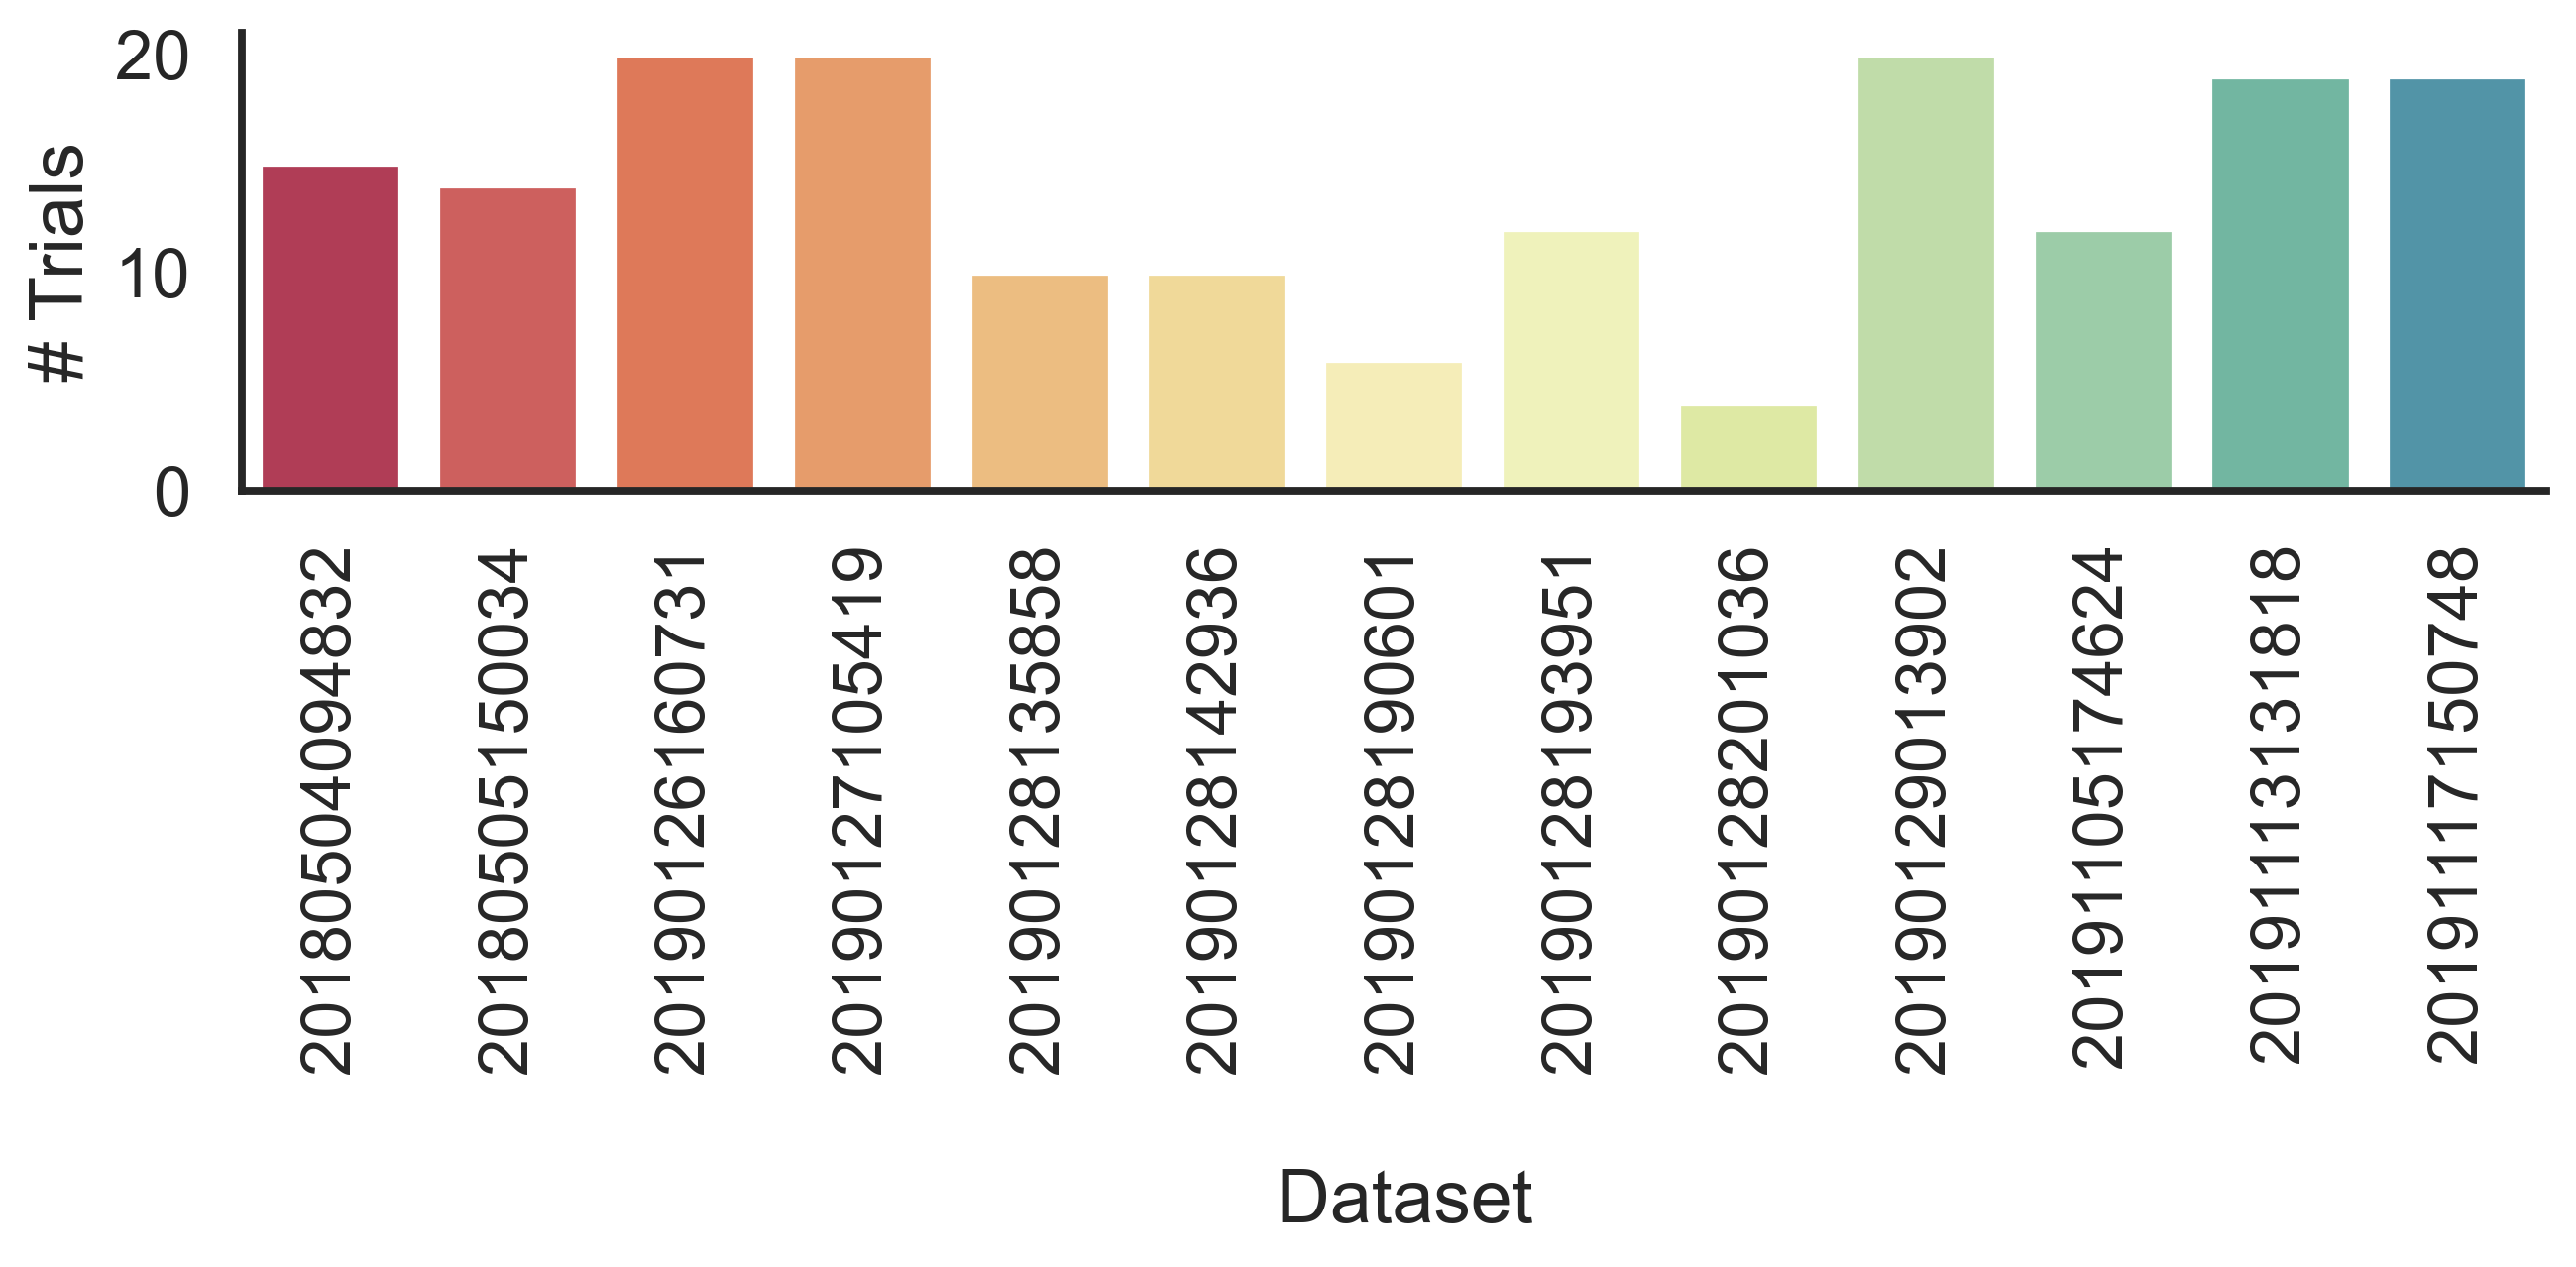

In [24]:
trials_per_session = position.groupby(['session_code']).trial_nr.nunique().reset_index()
sns.set(context=plot_context, style='white')
plt.figure(dpi=300, figsize=(10,2))
sns.barplot(
    data=trials_per_session,
    x='session_code',
    y='trial_nr',
    palette=colors
)
plt.xticks(rotation=90)
plt.xlabel('\n Dataset')
plt.ylabel('# Trials')
sns.despine()
plt.show()

### Removal of odd-positioned ripples

#### Number of events per session 

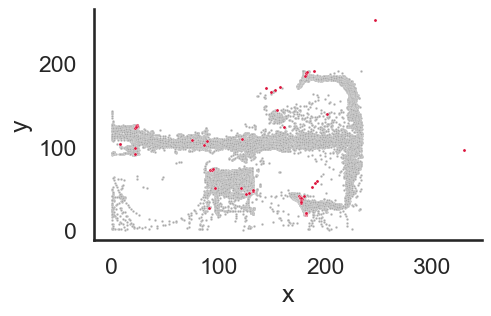

In [26]:
sns.set(style='white', context=plot_context)
session_code = 20180505150034
fig, ax = plt.subplots(figsize=(5,3))

# Plot position data
sns.scatterplot(
    data = position[position.session_code == session_code],
    x='x', 
    y='y', 
    color='darkgrey', 
    s=3, alpha=1,
    ax=ax
)
# Plot events
#for ax, s in zip(g.axes.flatten(), sessions):
sns.scatterplot(
    data=ripples[ripples.session_code == session_code],
    x= 'x_ripple',
    y='y_ripple', 
    color='crimson',
    s=5,
    ax=ax
)
  
sns.despine()

Session 20190128190601 from Magalhães has position data associated with the box that was not cleaned out during the ripple clean up. After checking the video, I confirmed that this position data - and corresponding ripples - are not trial bound. For this reason, I will remove them from the pool of SWR events to analyse. We can also find one SWR detected on session 20191113131818 that is clearly outside of the maze - probably due to a loss of position data. I will remove it too.

In [25]:
# Boolean mask to drop events from box in 20190128
to_drop_mask1 = (ripples['session_code']==20190128190601)&\
        (ripples['run_type']=='T') & (ripples['x_ripple'].between(70,170)) & ripples['y_ripple'].between(0,60)
# Boolean mask to drop event from 20191131
to_drop_mask2 = ripples['x_ripple']>270
# Boolean mask to drop events from 20190128201036 (trial outbound)
to_drop_mask3 = ripples['y_ripple']>200

ripples_clean = ripples[~(to_drop_mask1) & ~(to_drop_mask2) & ~(to_drop_mask3)]

### Events for analysis

N ripples for analysis: 1578


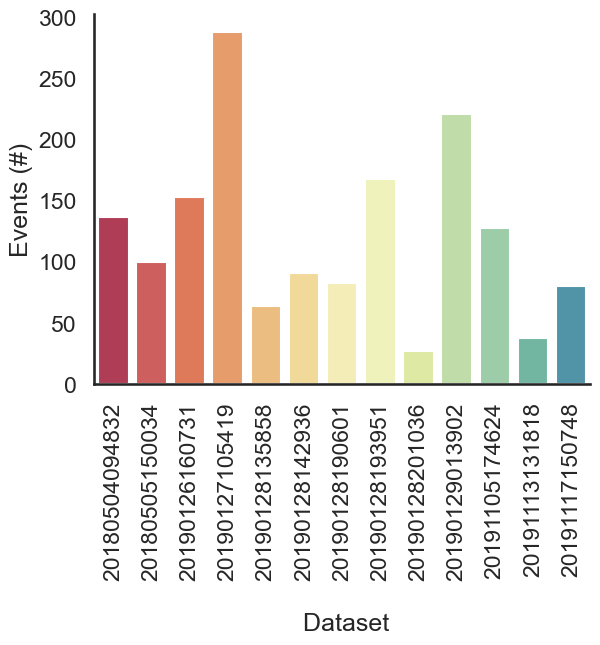

In [37]:
print('N ripples for analysis: {}'.format(len(ripples_clean)))

sns.set(context=plot_context, style='white')
plt.Figure(dpi=300, figsize=(10,2))
sns.countplot(
    x=ripples_clean['session_code'],
    palette=colors
)
plt.xticks(rotation=90)
plt.xlabel('\n Dataset')
plt.ylabel('Events (#)')
sns.despine()
plt.show()

### Ripple locations

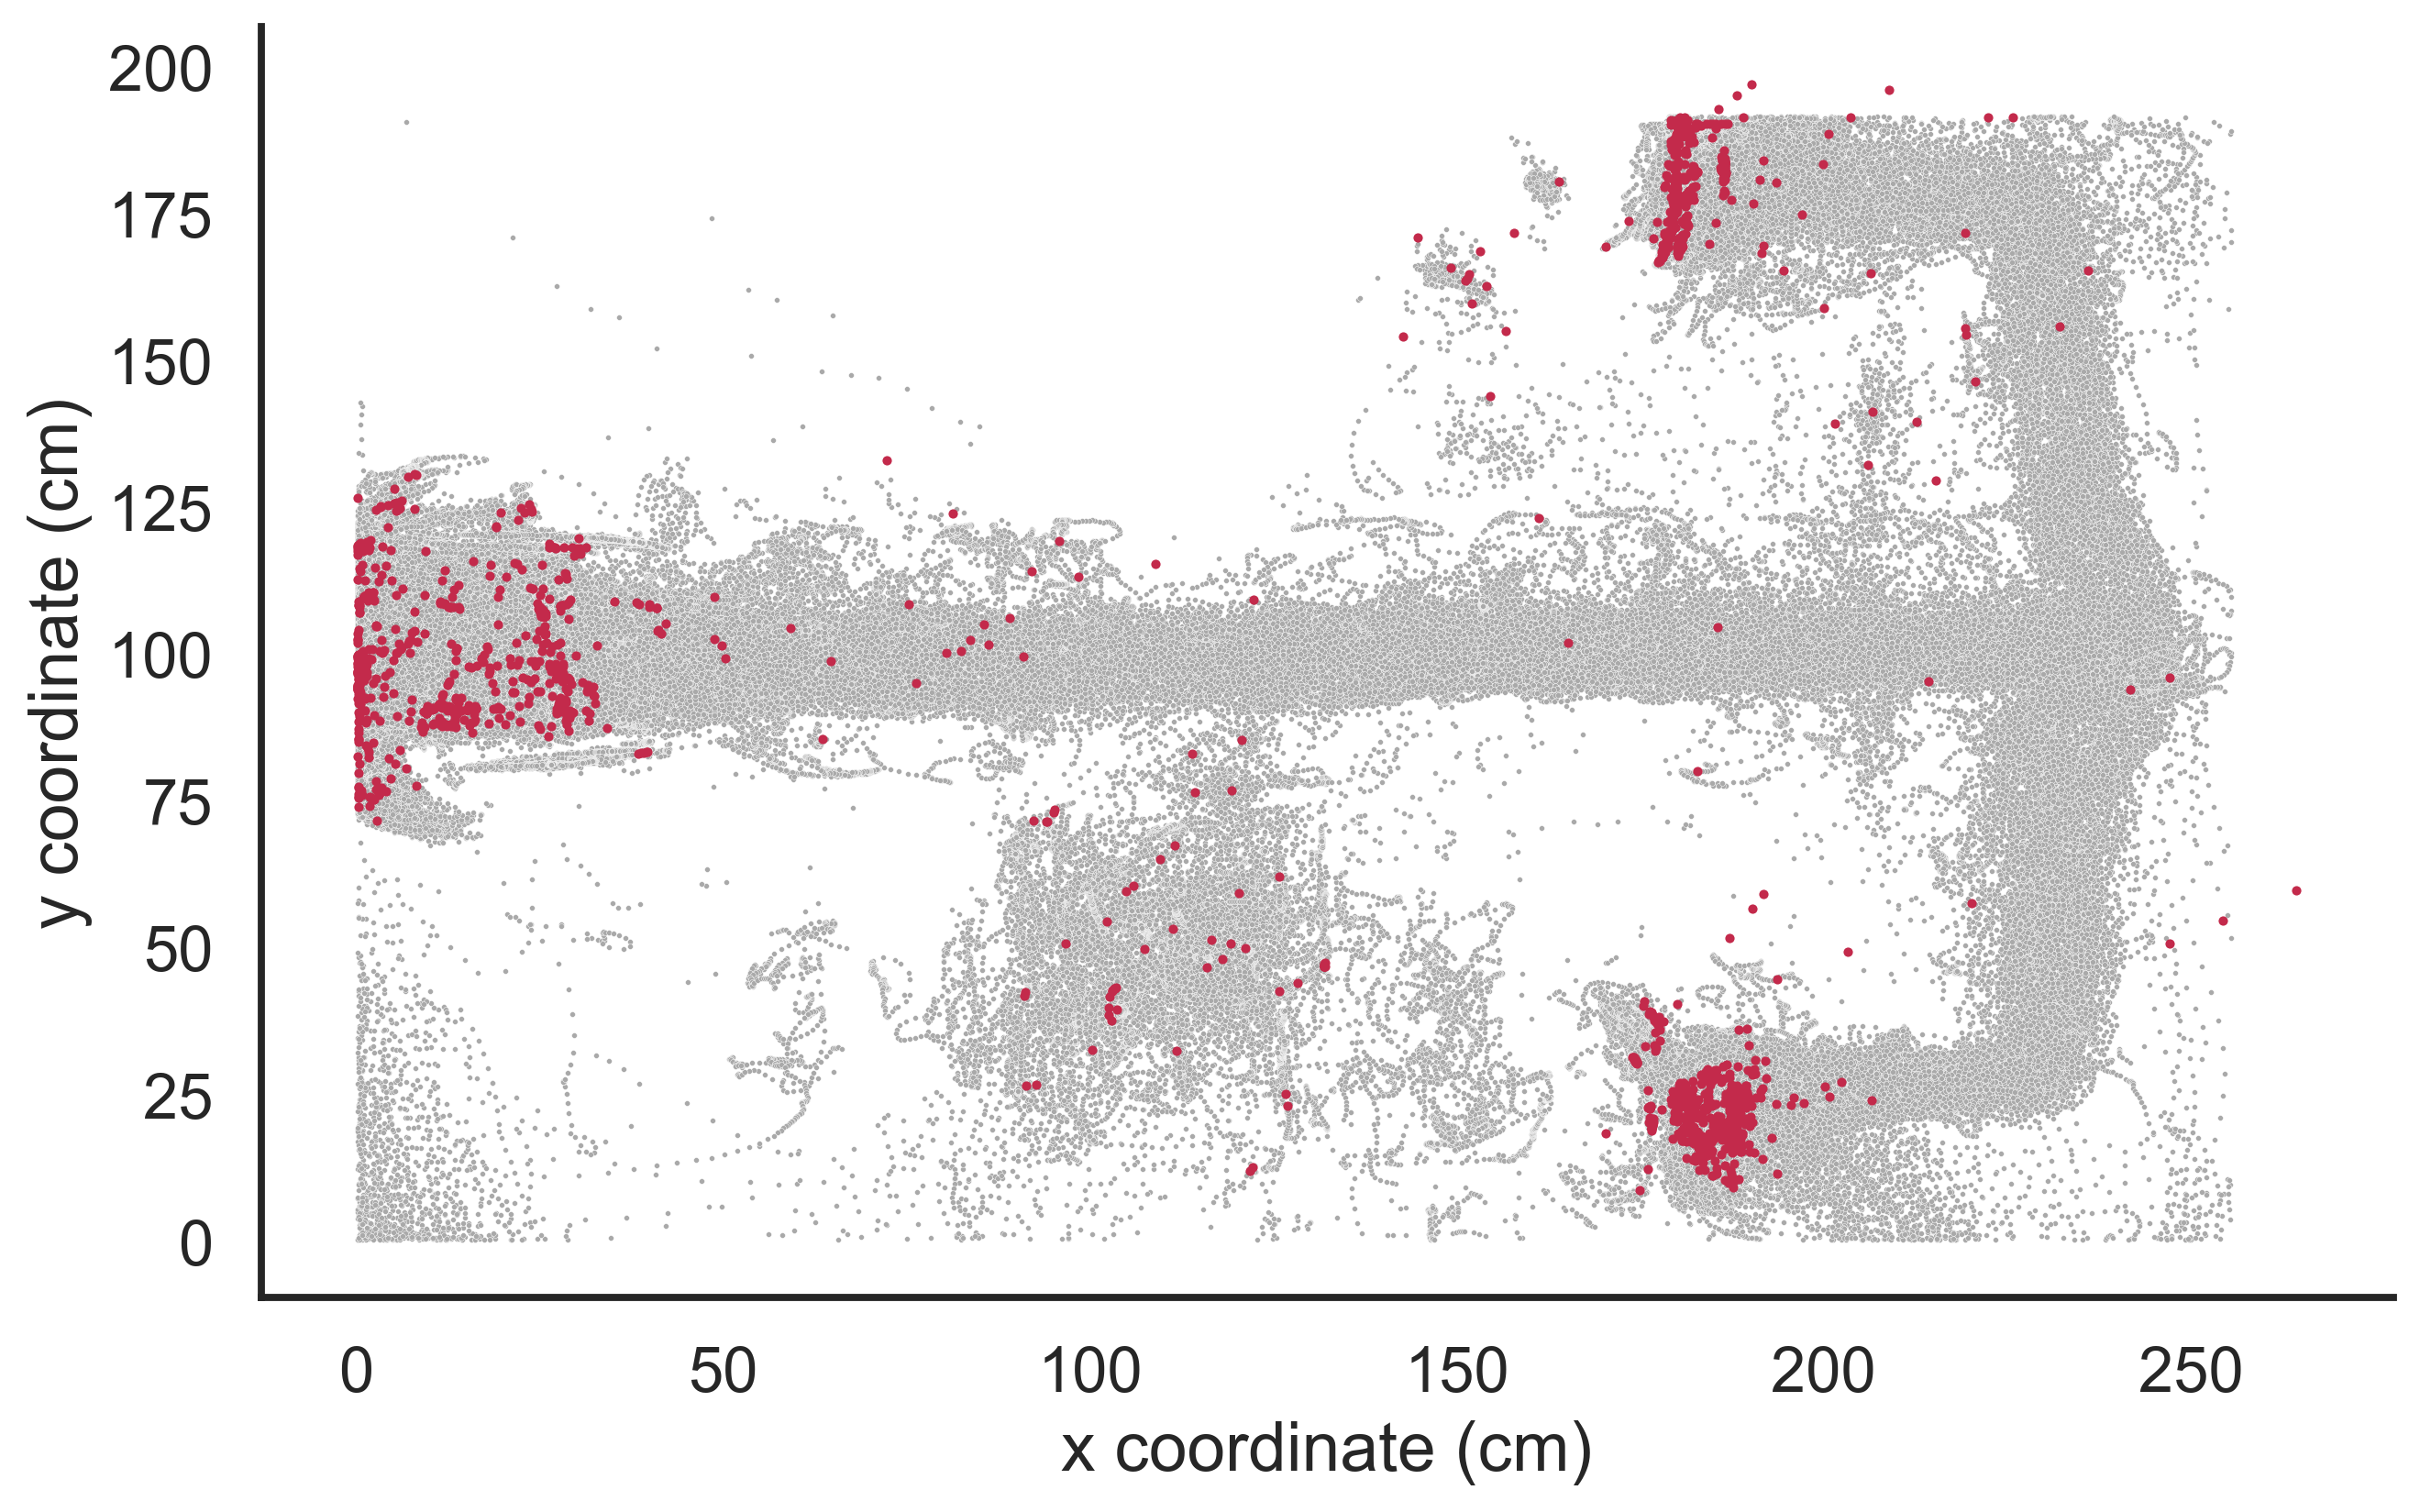

In [40]:
sns.set(style='white', context=plot_context)
plt.figure(dpi=300, figsize=(10,6))
# Plot position data
g=sns.scatterplot(
    data = position,
    x='x', 
    y='y', 
    color='darkgrey', 
    s=2, 
    alpha=1
)

# Plot events overlaid
sns.scatterplot(
    data = ripples_clean,
    x = 'x_ripple',
    y = 'y_ripple',
    color=colors[0],
    linewidth= 0,
    s=6)

plt.ylabel('y coordinate (cm)')
plt.xlabel('x coordinate (cm)')
sns.despine()

<br>
<br>

### Duration distributions - All events, not split by phase

In [43]:
# Calculate the duration of the events
ripples_clean['duration_sec']=ripples_clean['end_time']-ripples_clean['start_time']
ripples_clean['duration_ms']=ripples_clean['duration_sec']*1000
ripples_clean.duration_ms.describe()

count    1578.000000
mean       68.737262
std        35.782637
min        21.200000
25%        44.400000
50%        60.000000
75%        83.750000
max       340.400000
Name: duration_ms, dtype: float64

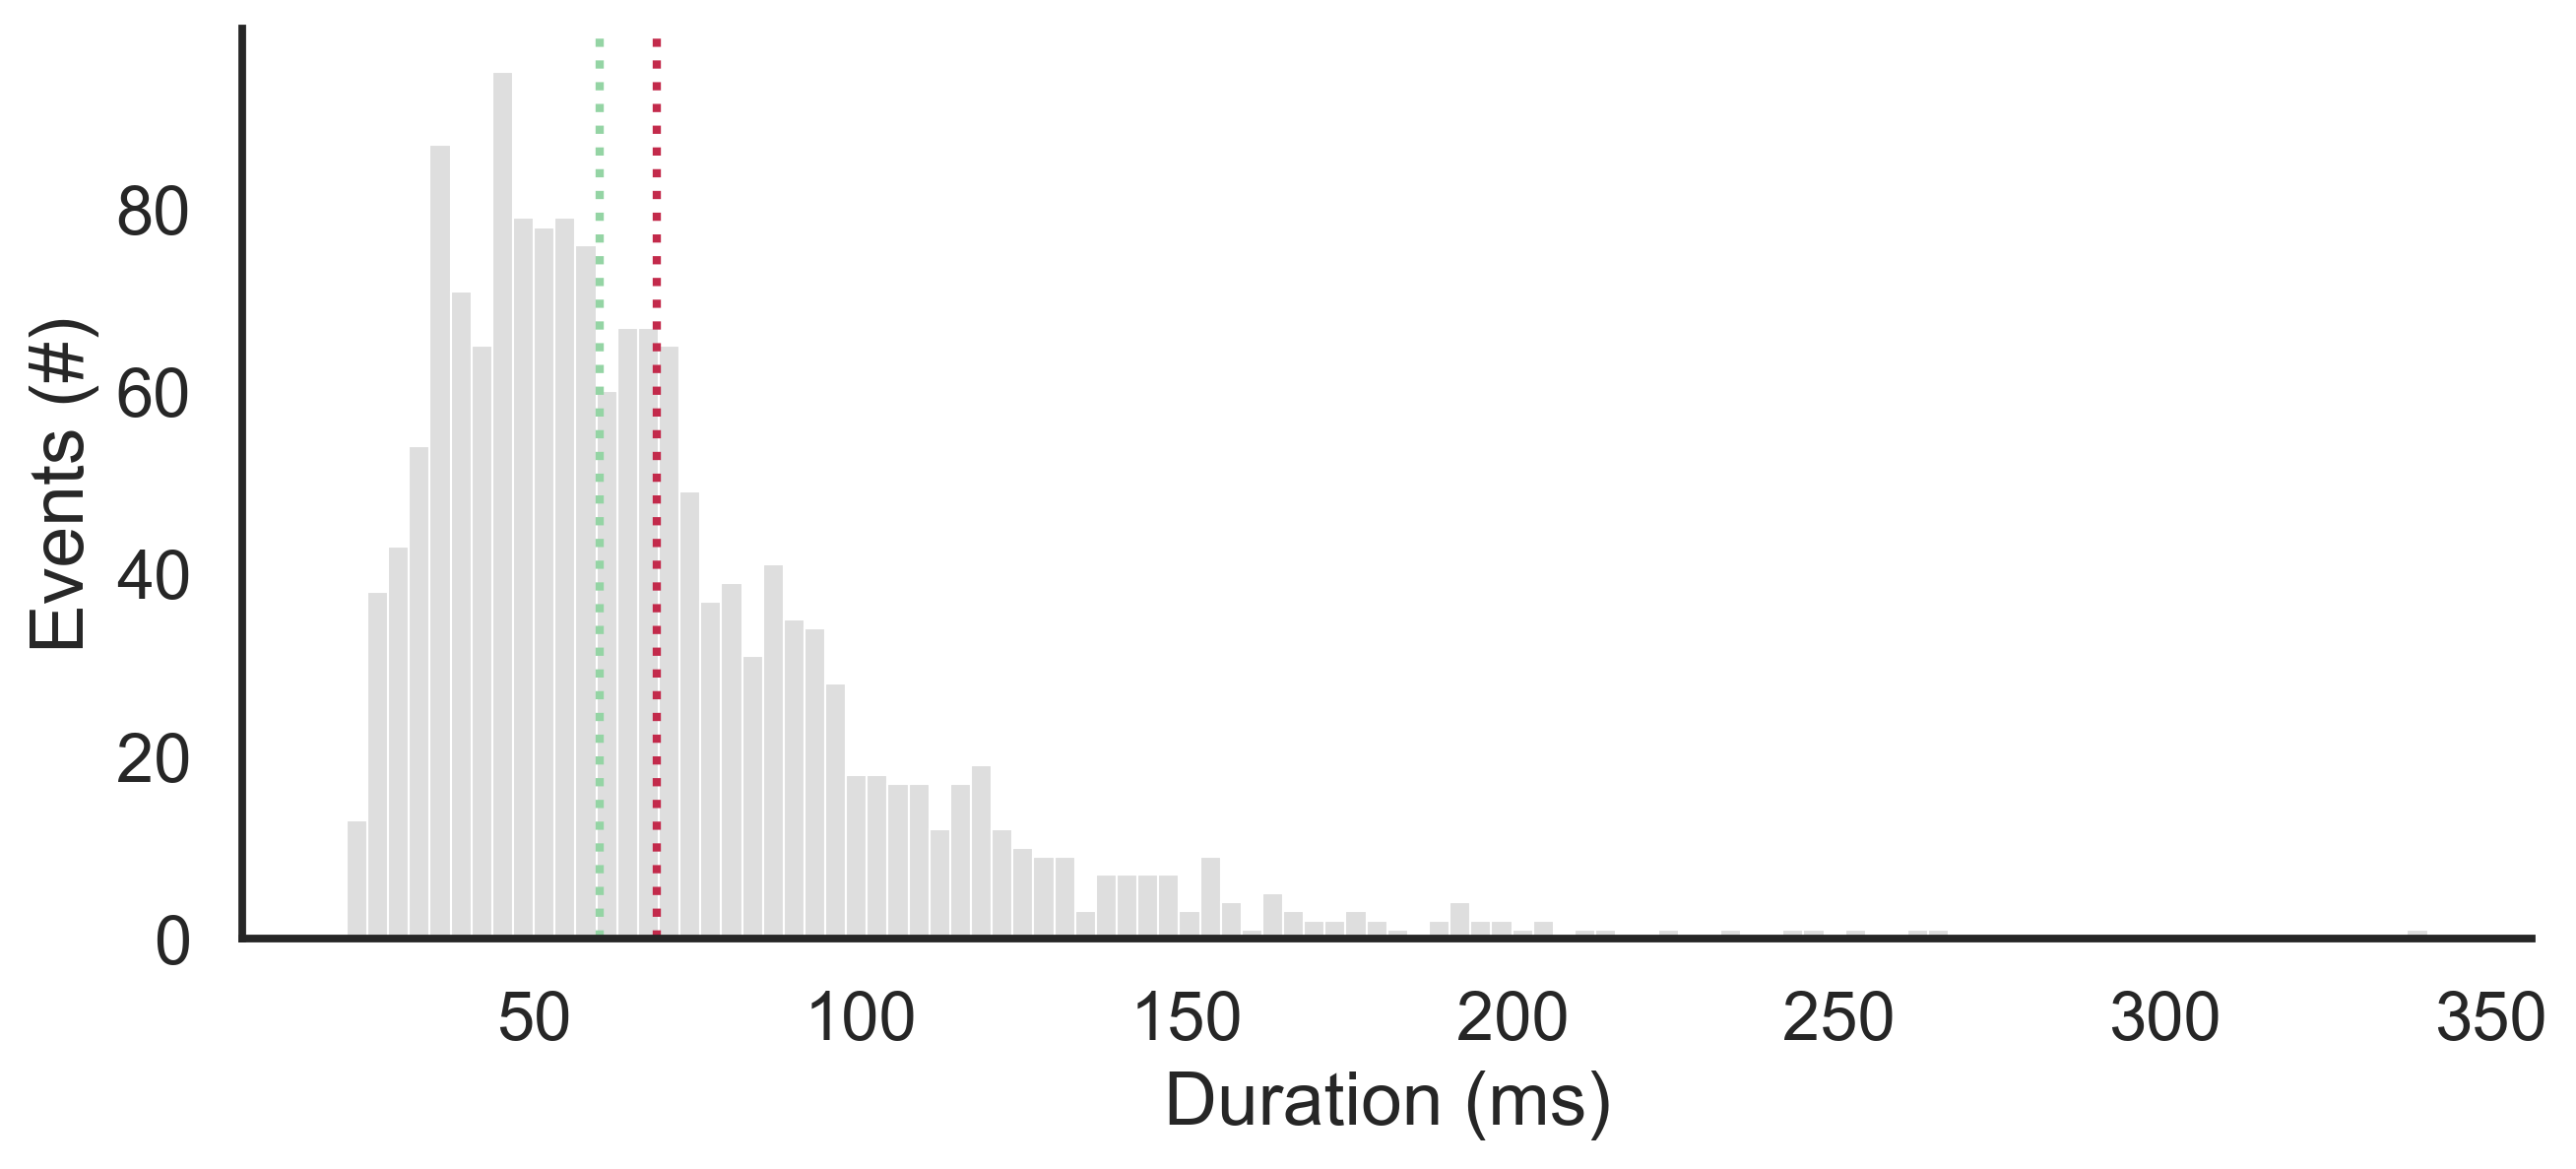

In [45]:
sns.set(style='white', context=plot_context)
plt.figure(dpi=300, figsize=(10,4))
g=sns.histplot( 
    data=ripples_clean, 
    x='duration_ms',
    color='lightgrey',
    bins=100
)
# Add average and median to distribution
plt.axvline(
    ripples_clean.duration_ms.describe().loc['mean'],
    color=colors[0], linewidth=2, linestyle=':'
)

plt.axvline(
    ripples_clean.duration_ms.describe().loc['50%'],
    color=colors[10], linewidth=2, linestyle=':'
)

plt.xlabel('Duration (ms)')
plt.ylabel('Events (#)')
sns.despine()

### Split by task phase

- Rate of occurrence (Hz) by task phase and trial outcome - per trial
- Distribution of ripple duration (ms) by task phase and trial outcome.

In [46]:
def divide_by_task_phase(df, start_rois, cp_rois, x, y):
    '''
    Each ripple will be classified as belonging to each task phase
    using the ROIs collected before.
    '''
    
    session_code=df.session_code
    session_start=start_rois.loc[start_rois['session_code']==session_code, 'x'].iloc[0]
    session_cp = cp_rois.loc[cp_rois['session_code']==session_code, 'x'].iloc[0]
    if df.run_type == 'S':
        if df[x] <= session_start:
            return 'ITI'
        if df[x]>session_start and df[x]< 150 and df[y]<=75:
            return 'ITI'
        else: 
            return 'Sample'
        
    elif  df.run_type=='T': 
        if df[x]<=session_start:
            return 'Delay'
        elif df[x] > session_start and df[x] <=session_cp and df[y]>= 60 and df[y] <=135:
            return 'Test (Pre-choice)'
        else:
            return 'Test (Past-choice)'

#### Classify by task phase

In [62]:
# Classify ripples by task phase
ripples_clean['phase'] = ripples_clean.apply(divide_by_task_phase, 
                                 args=(start_rois, cp_rois, 'x_ripple', 'y_ripple'), axis=1)

#Similar to the above but for each single position data point
position['phase'] = position.apply(divide_by_task_phase, 
                                 args=(start_rois, cp_rois, 'x', 'y'), axis=1)
# Save ripples dataframe
ripples_clean.to_csv(os.path.join(main_path, 'ripples_classified.csv'), index=False)

# There are so little Test(Pre-choice) events that I will drop pre-choice Test events
ripples_clean = ripples_clean.loc[~(ripples_clean['phase']=='Test (Pre-choice)')]
ripples_clean.loc[(ripples_clean['phase']=='Test (Past-choice)'), 'phase']='Test'
position.loc[(position['phase']=='Test (Pre-choice)')|(position['phase']=='Test (Past-choice)'),'phase']='Test'

ripples_clean.phase.value_counts()

phase
Sample    515
Test      404
Delay     346
ITI       296
Name: count, dtype: int64

In [63]:
ripples_clean.groupby(['outcome'])['start_time'].count()

outcome
0.0     250
1.0    1311
Name: start_time, dtype: int64

In [64]:
ripples_clean.groupby(['phase','outcome'])['start_time'].count()

phase   outcome
Delay   0.0        103
        1.0        243
ITI     0.0         61
        1.0        235
Sample  0.0         73
        1.0        442
Test    0.0         13
        1.0        391
Name: start_time, dtype: int64

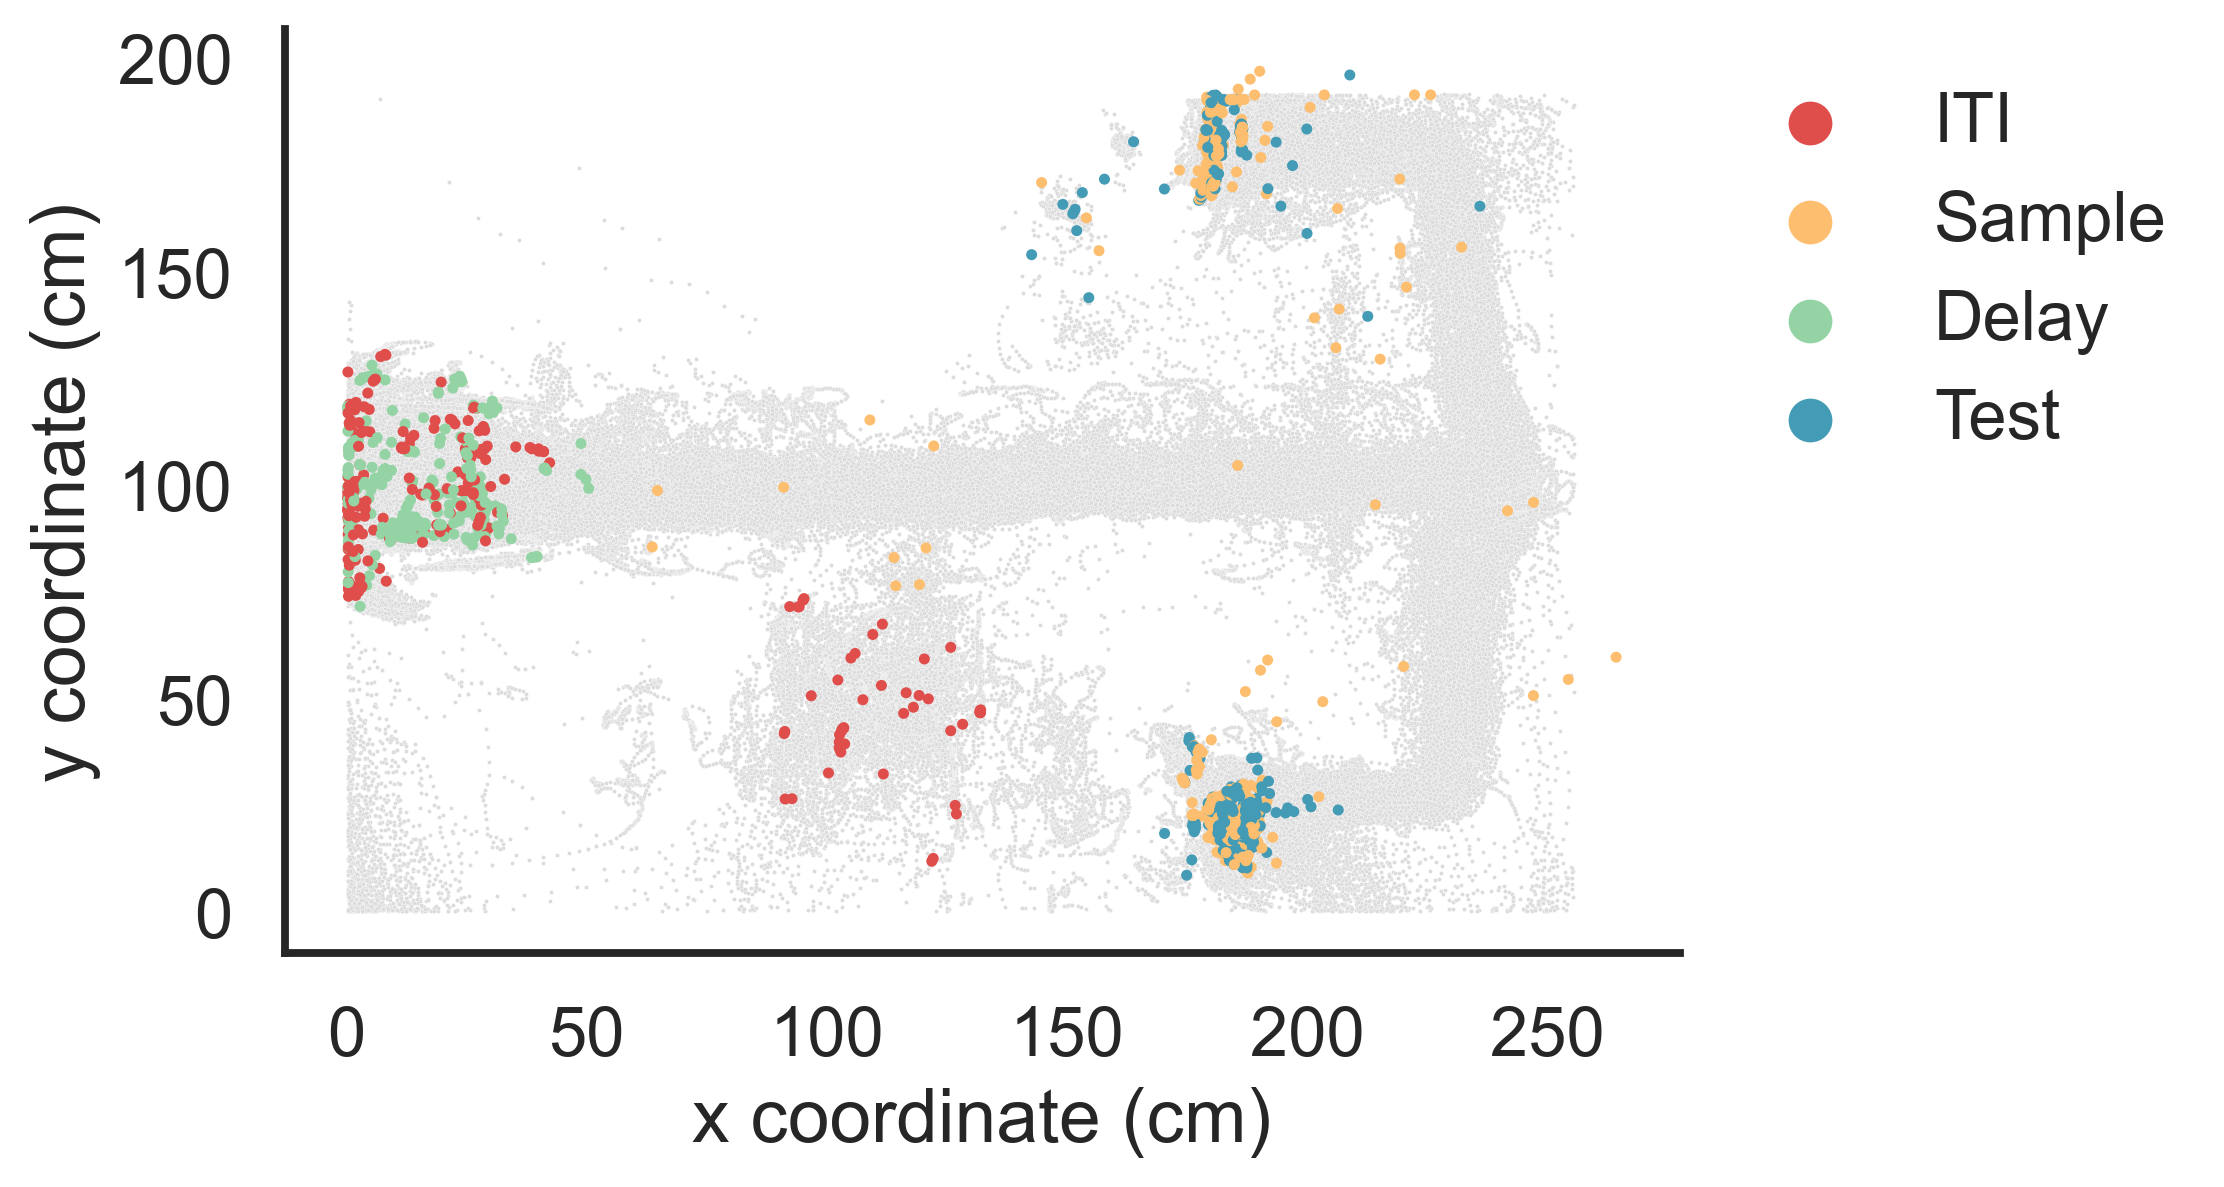

In [65]:
sns.set(style='white', context=plot_context)
plt.figure(dpi=300, figsize=(6,4))
order = ['ITI', 'Sample', 'Delay', 'Test']

g = sns.scatterplot(data = position, x='x', y='y', color='gainsboro', s=1, alpha=1)

sns.scatterplot(
    data = ripples_clean,
    x='x_ripple', y='y_ripple', hue='phase', s=7, alpha=1,
    hue_order=order, palette=phase_palette, linewidth=0)

plt.ylabel('y coordinate (cm)')
plt.xlabel('x coordinate (cm)')
plt.legend(bbox_to_anchor=(1,1), frameon=False)
sns.despine()

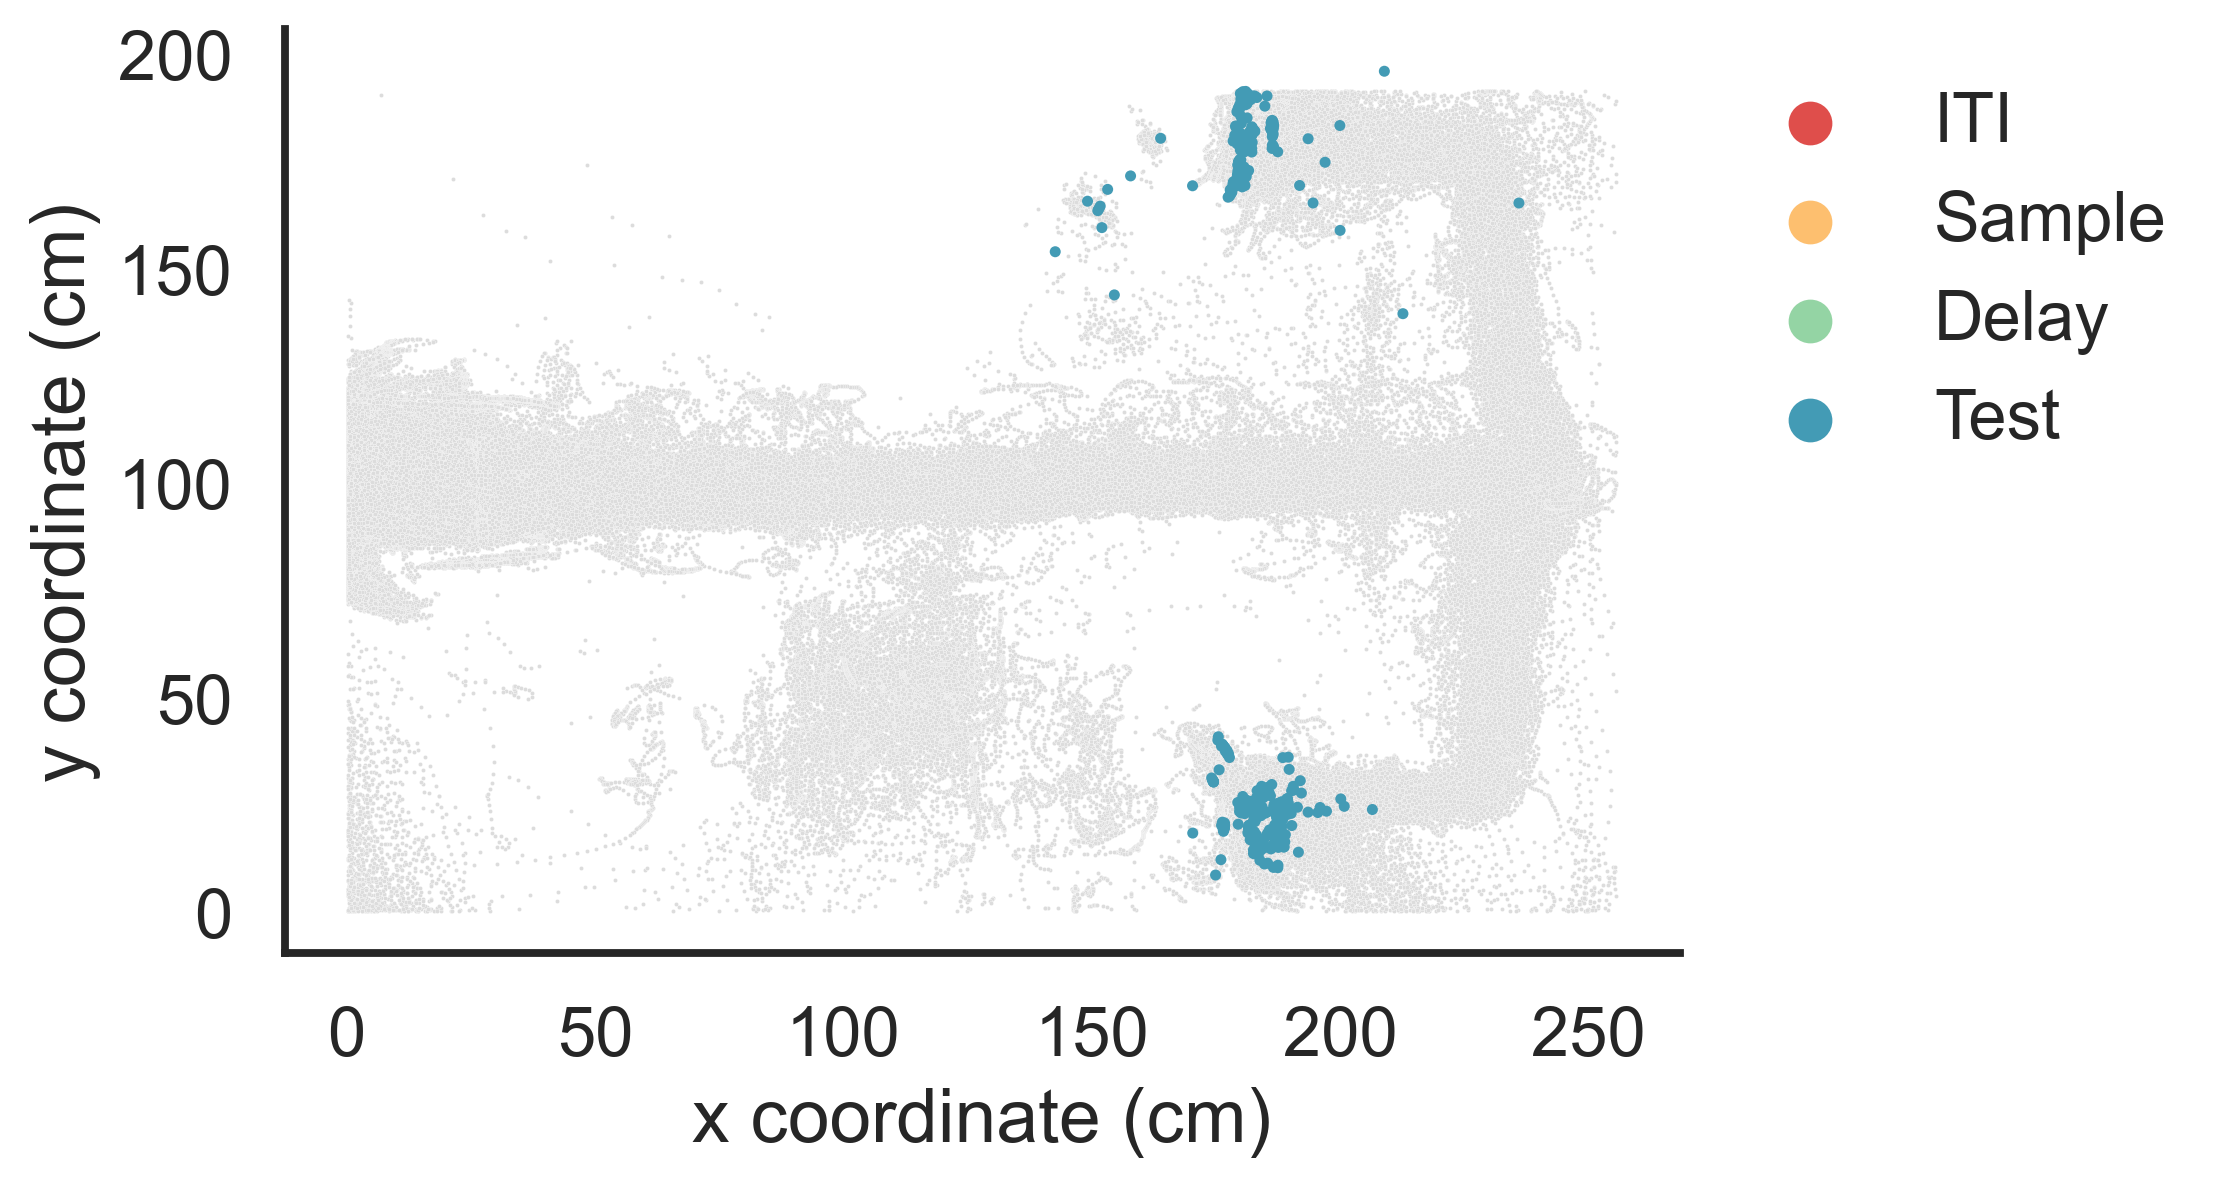

In [66]:
sns.set(style='white', context=plot_context)
plt.figure(dpi=300, figsize=(6,4))

g = sns.scatterplot(data = position, x='x', y='y', color='gainsboro', s=1, alpha=1)

sns.scatterplot(
    data = ripples_clean[ripples_clean.phase=='Test'],
    x='x_ripple', y='y_ripple', hue='phase', s=7,  alpha=1,
    hue_order=order, palette=phase_palette, linewidth=0)

plt.ylabel('y coordinate (cm)')
plt.xlabel('x coordinate (cm)')
plt.legend(bbox_to_anchor=(1,1), frameon=False)
sns.despine()

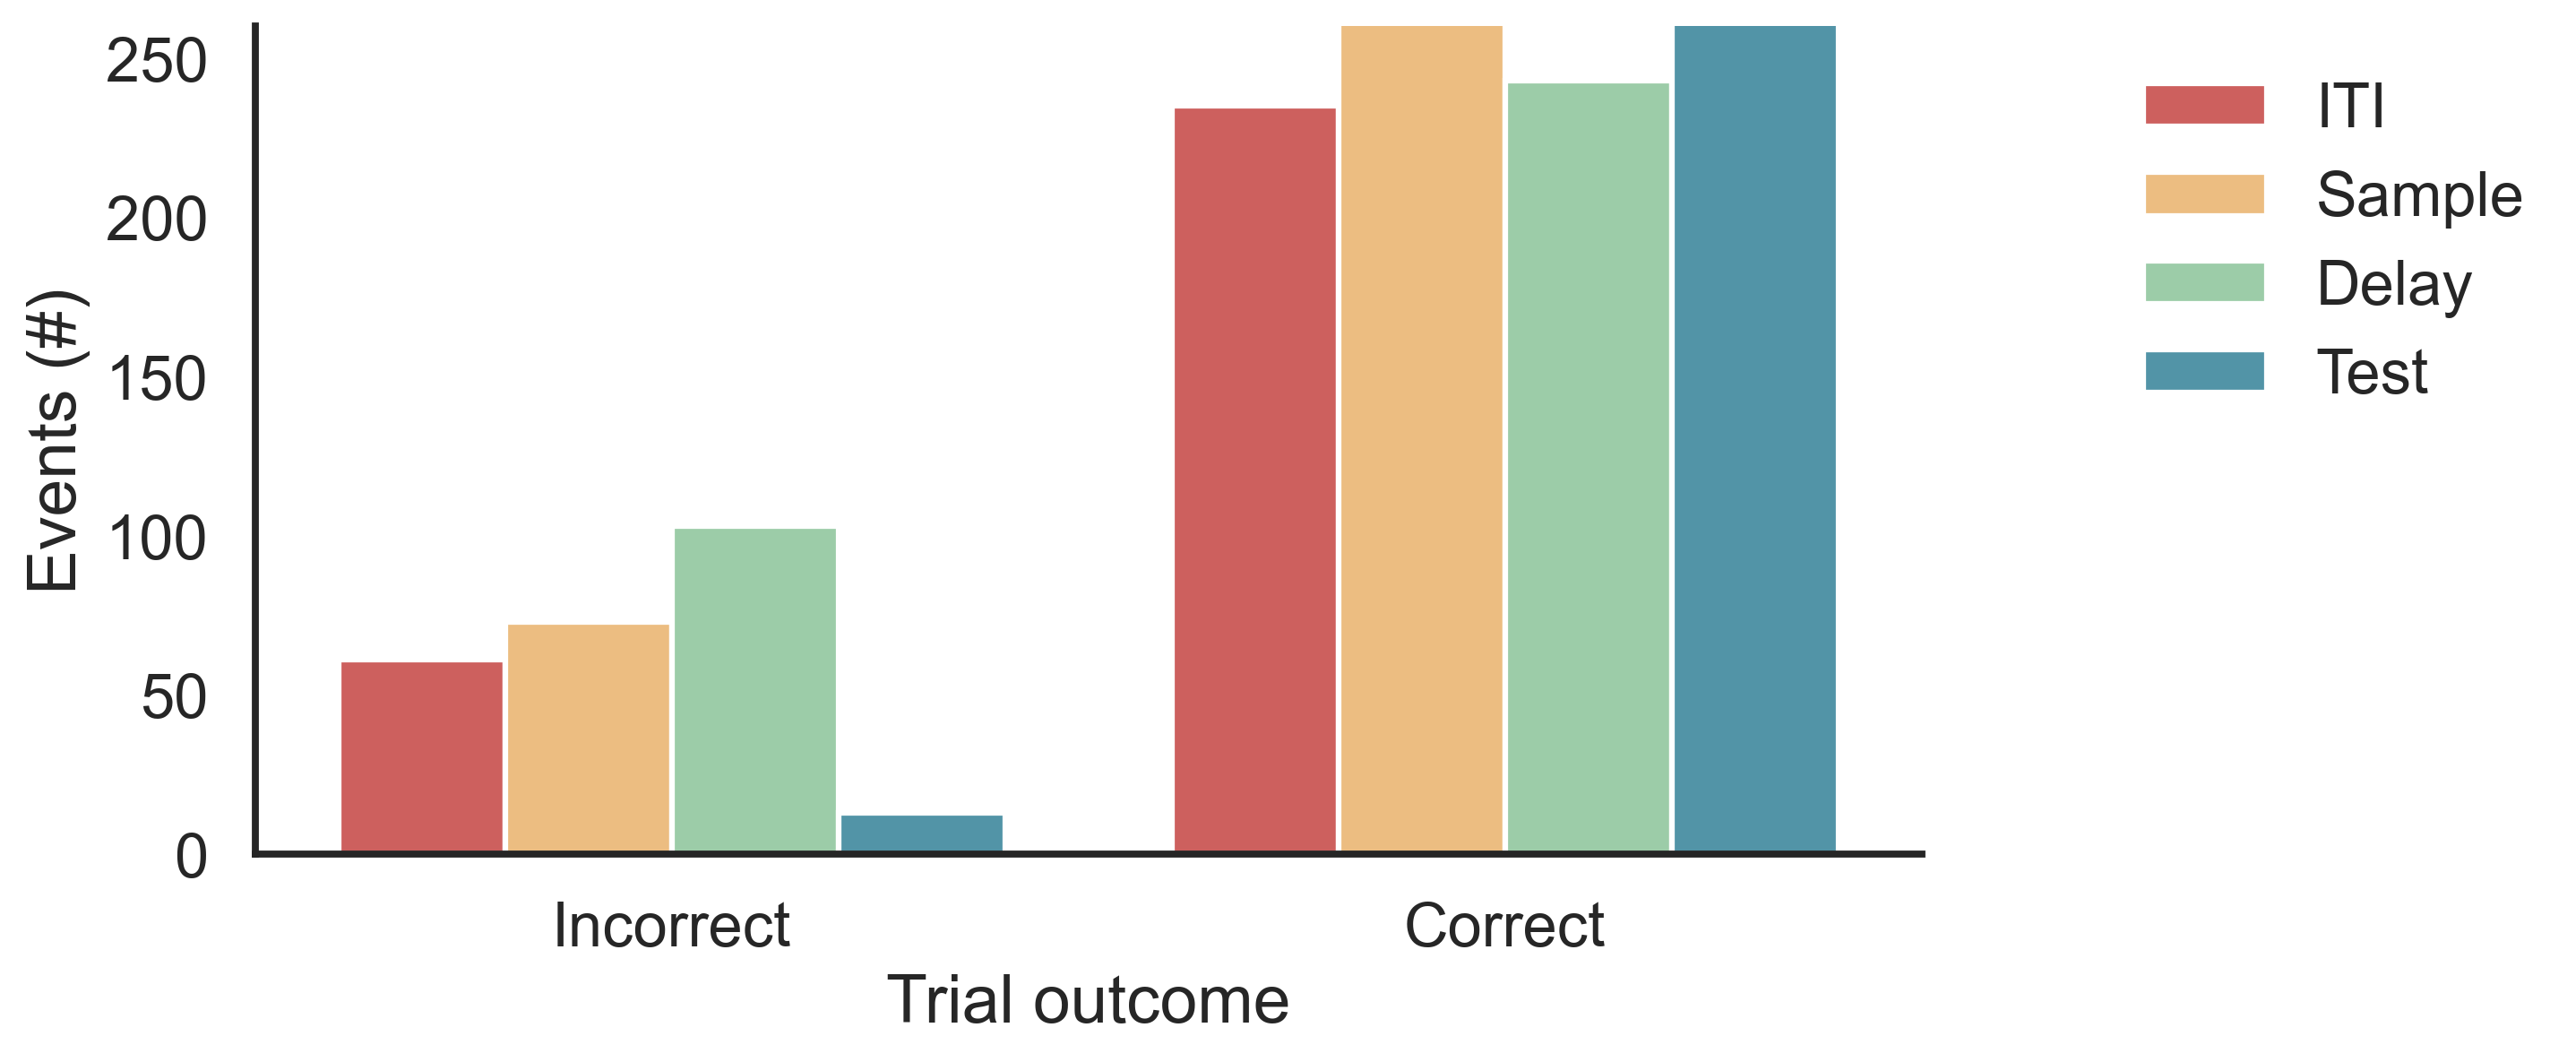

In [67]:
sns.set(style='white', context=plot_context)
plt.figure(figsize=(8,4), dpi=300)

g= sns.countplot(data=ripples_clean,  x='outcome', hue='phase', palette=phase_palette, hue_order=order)

g.set_xlabel('Trial outcome')
g.set_ylabel('Events (#)')
g.set_ylim([0,260])
g.set_xticklabels(['Incorrect', 'Correct'])
plt.legend(bbox_to_anchor=(1.1,1), frameon=False)
sns.despine()

<br>

### Rate by task phase (all trials)

The number of ripples in each phase by the amount of time spent in that phase. 
Sum( # events in task phase) / Sum ( # time spent in task phase), per trial.
So each point represents 1 trial phase (1 phase from 1 trial)

In [68]:
# Calculate time spent in each task phase and trial (denominator)
phase_durations = position.groupby(['session_code', 'trial_nr', 'phase'])['timestamp'].agg(['min', 'max'])
phase_durations['duration_s'] = phase_durations['max']-phase_durations['min']

# Calculate ripples per trial
ripple_count=ripples_clean.groupby(['session_code', 'trial_nr','phase'])['start_time'].count(
    ).reset_index(
    ).rename(
    {'start_time':'ripples'}, axis=1)

# Combine both datasets (count of events per dataset and task phase)
rate_by_phase = pd.merge(
    phase_durations, ripple_count,
    how='left', on=['session_code', 'trial_nr','phase']
).fillna(0)

# Calculate the rate per task phase and dataset
rate_by_phase['rate']=rate_by_phase['ripples']/rate_by_phase['duration_s']
rate_by_phase.groupby(['phase'])['rate'].describe()

count      mean       std  min  25%       50%       75%       max
phase                                                                    
Delay   181.0  0.041183  0.057952  0.0  0.0  0.025177  0.058164  0.287240
ITI     180.0  0.033964  0.051315  0.0  0.0  0.000000  0.043971  0.279688
Sample  180.0  0.108055  0.114701  0.0  0.0  0.069237  0.186345  0.432880
Test    181.0  0.083328  0.103069  0.0  0.0  0.044393  0.138080  0.465852

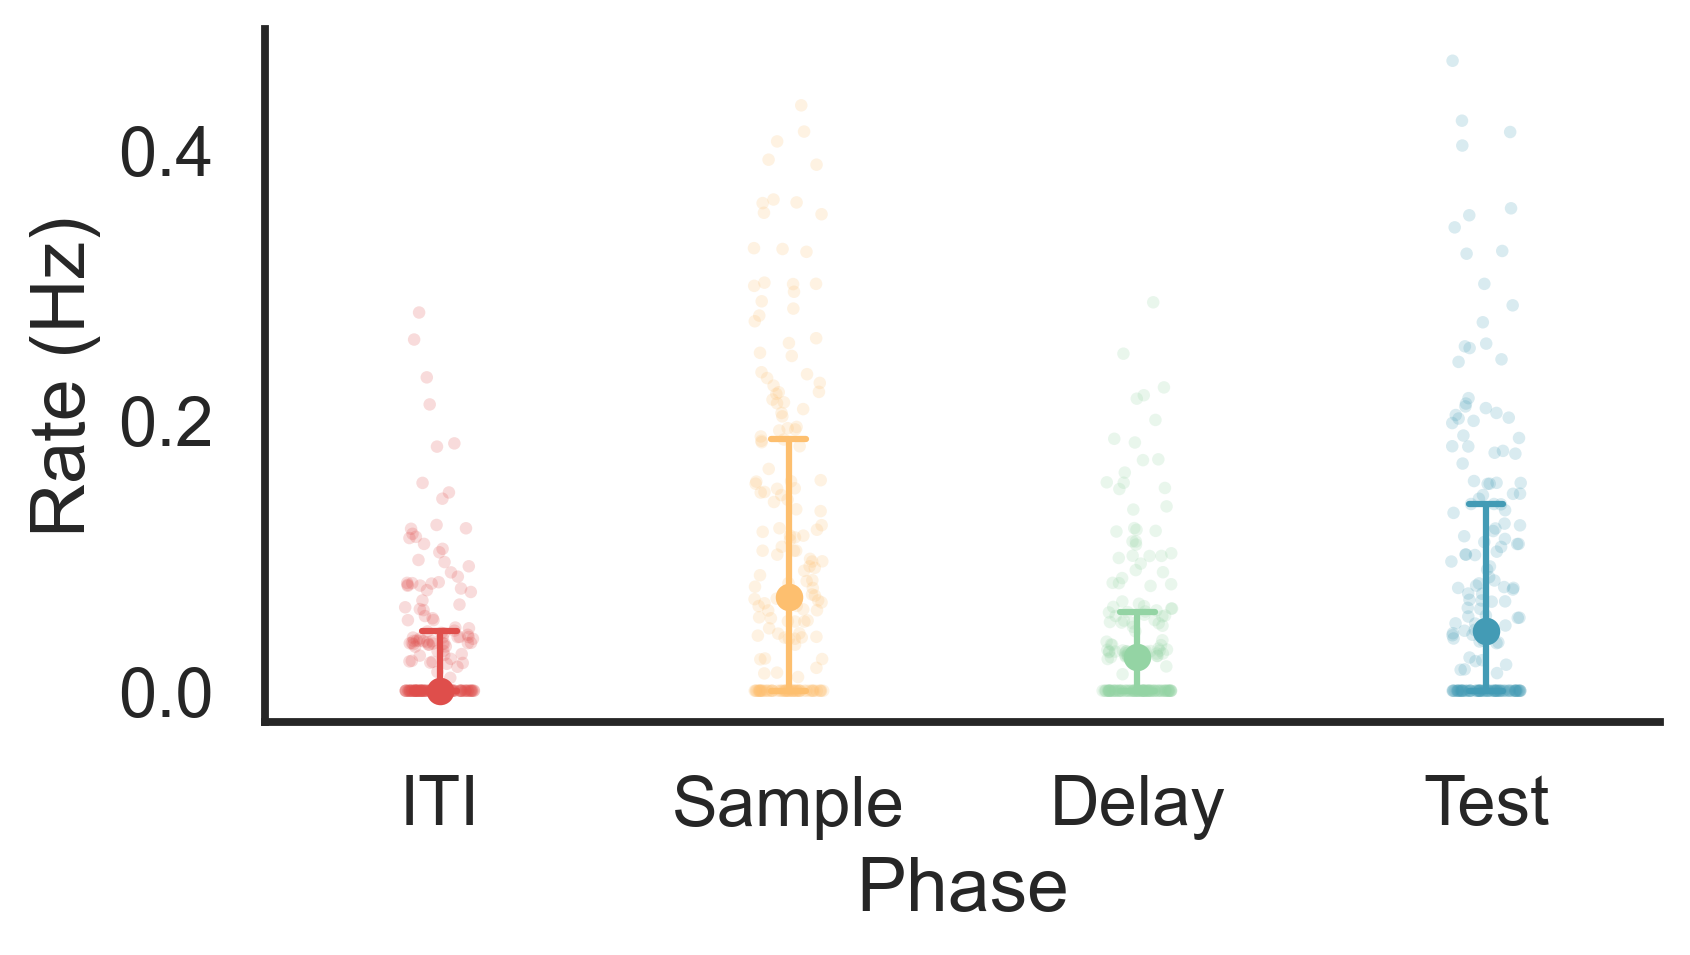

In [123]:
sns.set(style='white', context=plot_context)
plt.figure(figsize=(6,3), dpi=300)

g=sns.stripplot(
    data=rate_by_phase,  x='phase', y='rate', hue='phase', 
    palette=phase_palette, hue_order=order, order=order, s=3, linewidth=0, alpha=.2, jitter=.1
)

sns.pointplot(
    data=rate_by_phase,  x='phase', y='rate', hue='phase',
    palette=phase_palette, hue_order=order, order=order, estimator=np.median, 
    dodge=False, errorbar=(('pi', 50)), errwidth=1.5,  capsize=.1, markers= "o", scale=.5
)

g.set_xlabel('Phase')
g.set_ylabel('Rate (Hz)')
g.get_legend().remove()
sns.despine()

In [70]:
# Perform the Kruskal-Wallis H-test
stat, p = kruskal(
    rate_by_phase.loc[rate_by_phase.phase=='ITI','rate'],    
    rate_by_phase.loc[rate_by_phase.phase=='Sample','rate'],     
    rate_by_phase.loc[rate_by_phase.phase=='Delay','rate'],    
    rate_by_phase.loc[rate_by_phase.phase=='Test','rate']
)

print('H: {}, p={}'.format(stat, p))

# Perform pairwise comparisons 
pairwise_results = pg.pairwise_tests(
    dv='rate', between='phase', data=rate_by_phase, padjust='bonf', parametric=False #Uses pingouin.mwu()
)
print(pairwise_results)

H: 55.69018089092017, p=4.891687414981268e-12
  Contrast       A       B  Paired  Parametric    U-val alternative  \
0    phase   Delay     ITI   False       False  17179.5   two-sided   
1    phase   Delay  Sample   False       False  10879.0   two-sided   
2    phase   Delay    Test   False       False  13101.5   two-sided   
3    phase     ITI  Sample   False       False   9994.0   two-sided   
4    phase     ITI    Test   False       False  12102.5   two-sided   
5    phase  Sample    Test   False       False  18381.0   two-sided   

          p-unc        p-corr p-adjust    hedges  
0  3.413053e-01  1.000000e+00     bonf  0.131587  
1  1.905994e-08  1.143596e-07     bonf -0.734983  
2  6.082334e-04  3.649400e-03     bonf -0.503016  
3  7.461798e-11  4.477079e-10     bonf -0.832120  
4  9.500730e-06  5.700438e-05     bonf -0.604563  
5  3.107270e-02  1.864362e-01     bonf  0.226329  


<br>

### Rate for trials with ripples

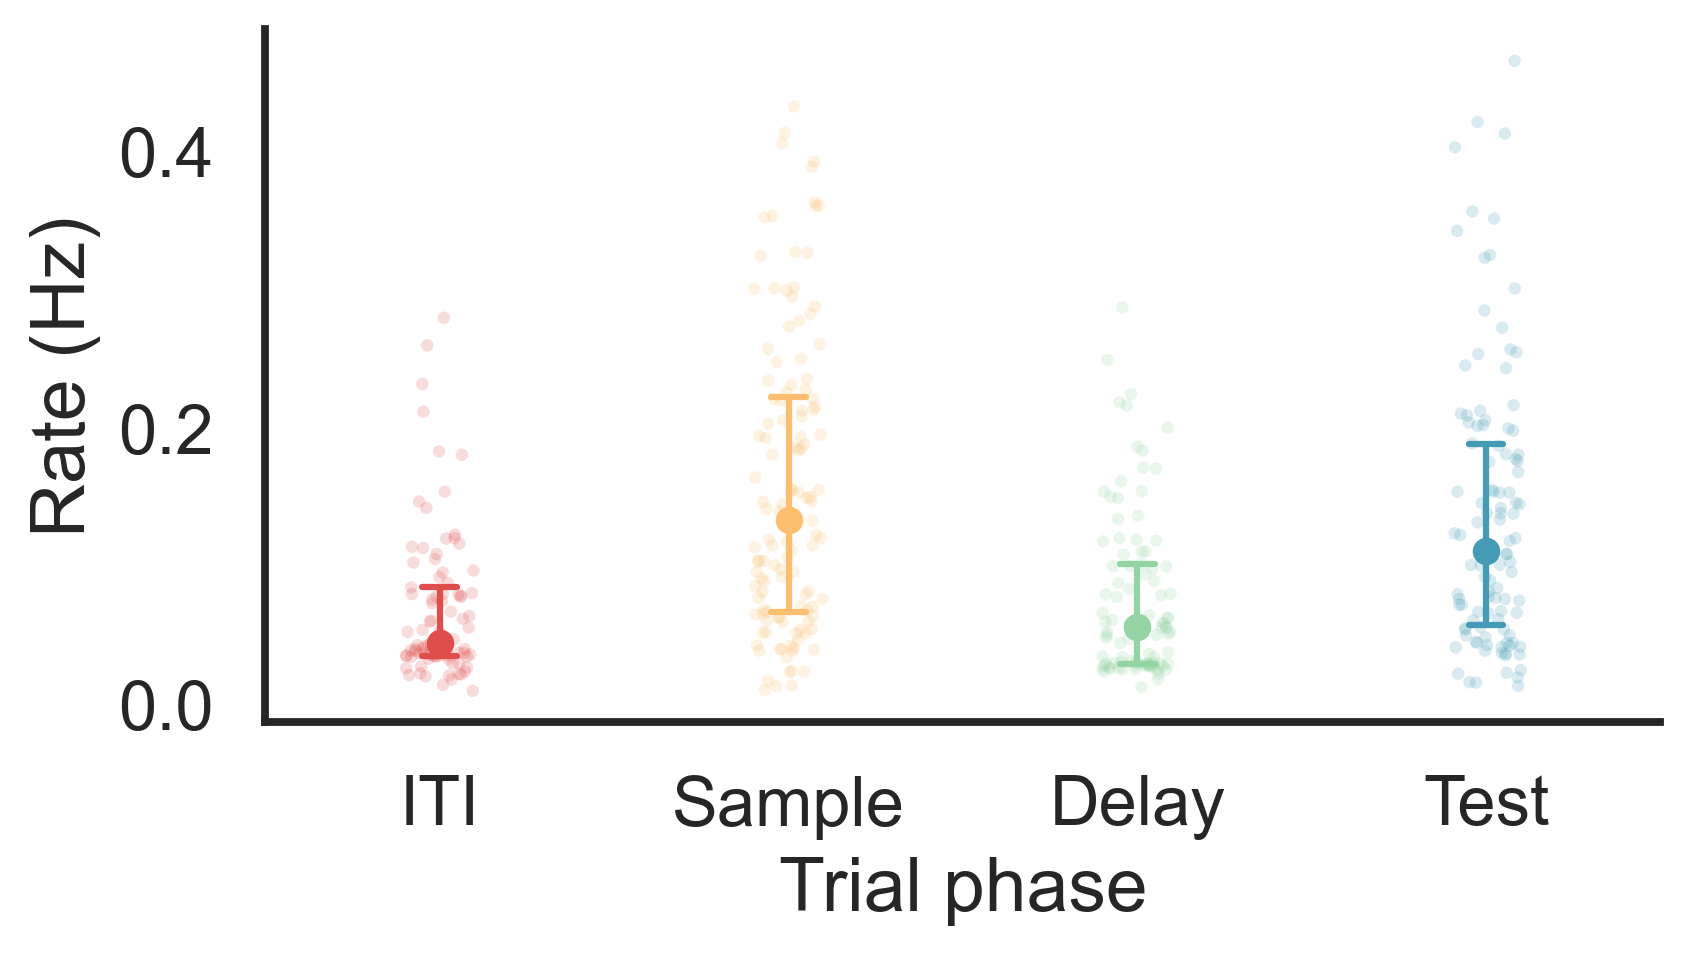

In [72]:
rate_by_phase_above0 = rate_by_phase[rate_by_phase.ripples > 0]
rate_by_phase_above0.groupby(['phase'])['rate'].describe()

sns.set(style='white', context=plot_context)
plt.figure(figsize=(6,3), dpi=300)

g=sns.stripplot(
    data=rate_by_phase_above0,  x='phase', y='rate', hue='phase',
    palette=phase_palette, hue_order=order, order=order, s=3, linewidth=0, alpha=.2, jitter=.1)

sns.pointplot(
    data=rate_by_phase_above0,  x='phase', y='rate', hue='phase',
    palette=phase_palette, hue_order=order, order=order,
    estimator=np.median, dodge=False, errorbar=(('pi', 50)),
    errwidth=1.5,  capsize=.1, markers= "o", scale=.5
)

g.set_xlabel('Trial phase')
g.set_ylabel('Rate (Hz)')
g.get_legend().remove()
sns.despine()

In [73]:
# Perform the Kruskal-Wallis H-test
stat, p = kruskal(
    rate_by_phase_above0.loc[rate_by_phase.phase=='ITI','rate'],    
    rate_by_phase_above0.loc[rate_by_phase.phase=='Sample','rate'],     
    rate_by_phase_above0.loc[rate_by_phase.phase=='Delay','rate'],    
    rate_by_phase_above0.loc[rate_by_phase.phase=='Test','rate']
)

print(stat, p)

# Perform pairwise comparisons using Dunn's test
pairwise_results = pg.pairwise_tests(
    dv='rate', between='phase', data=rate_by_phase_above0, padjust='bonf', parametric=False #Uses pingouin.mwu()
)
print(pairwise_results)

75.06239119209067 3.5134556326500875e-16
  Contrast       A       B  Paired  Parametric   U-val alternative  \
0    phase   Delay     ITI   False       False  4485.0   two-sided   
1    phase   Delay  Sample   False       False  3067.0   two-sided   
2    phase   Delay    Test   False       False  3197.0   two-sided   
3    phase     ITI  Sample   False       False  2462.0   two-sided   
4    phase     ITI    Test   False       False  2553.0   two-sided   
5    phase  Sample    Test   False       False  7589.0   two-sided   

          p-unc        p-corr p-adjust    hedges  
0  7.383075e-01  1.000000e+00     bonf  0.128516  
1  2.437612e-10  1.462567e-09     bonf -0.902679  
2  4.193286e-07  2.515972e-06     bonf -0.726159  
3  5.679044e-12  3.407427e-11     bonf -0.988983  
4  6.764534e-09  4.058720e-08     bonf -0.820345  
5  1.370307e-01  8.221843e-01     bonf  0.189303  


<br>

### Rate by outcome

In [74]:
# Calculate time spent in trial (denominator)
trial_durations = position.groupby(['session_code', 'trial_nr', 'outcome'])['timestamp'].agg(['min', 'max'])
trial_durations['duration_s'] = trial_durations['max'] - trial_durations['min']

# Calculate ripples per trial
ripple_count=ripples_clean.groupby(['session_code', 'trial_nr', 'outcome'])['start_time'].count(
    ).reset_index(
    ).rename(
    {'start_time':'ripples'}, axis=1
    )

# Combine both datasets (count of events per dataset and task phase)
rate_by_outcome = pd.merge(
    trial_durations, ripple_count,
    how='left', on=['session_code', 'trial_nr', 'outcome']
).fillna(0)

# Calculate the rate per task phase and dataset
rate_by_outcome['rate']=rate_by_phase['ripples']/rate_by_phase['duration_s']
rate_by_outcome.groupby(['outcome'])['rate'].describe()

count      mean       std  min  25%       50%       75%       max
outcome                                                                   
0.0       33.0  0.062023  0.092229  0.0  0.0  0.010137  0.078758  0.301785
1.0      148.0  0.050734  0.082666  0.0  0.0  0.013673  0.062842  0.421528

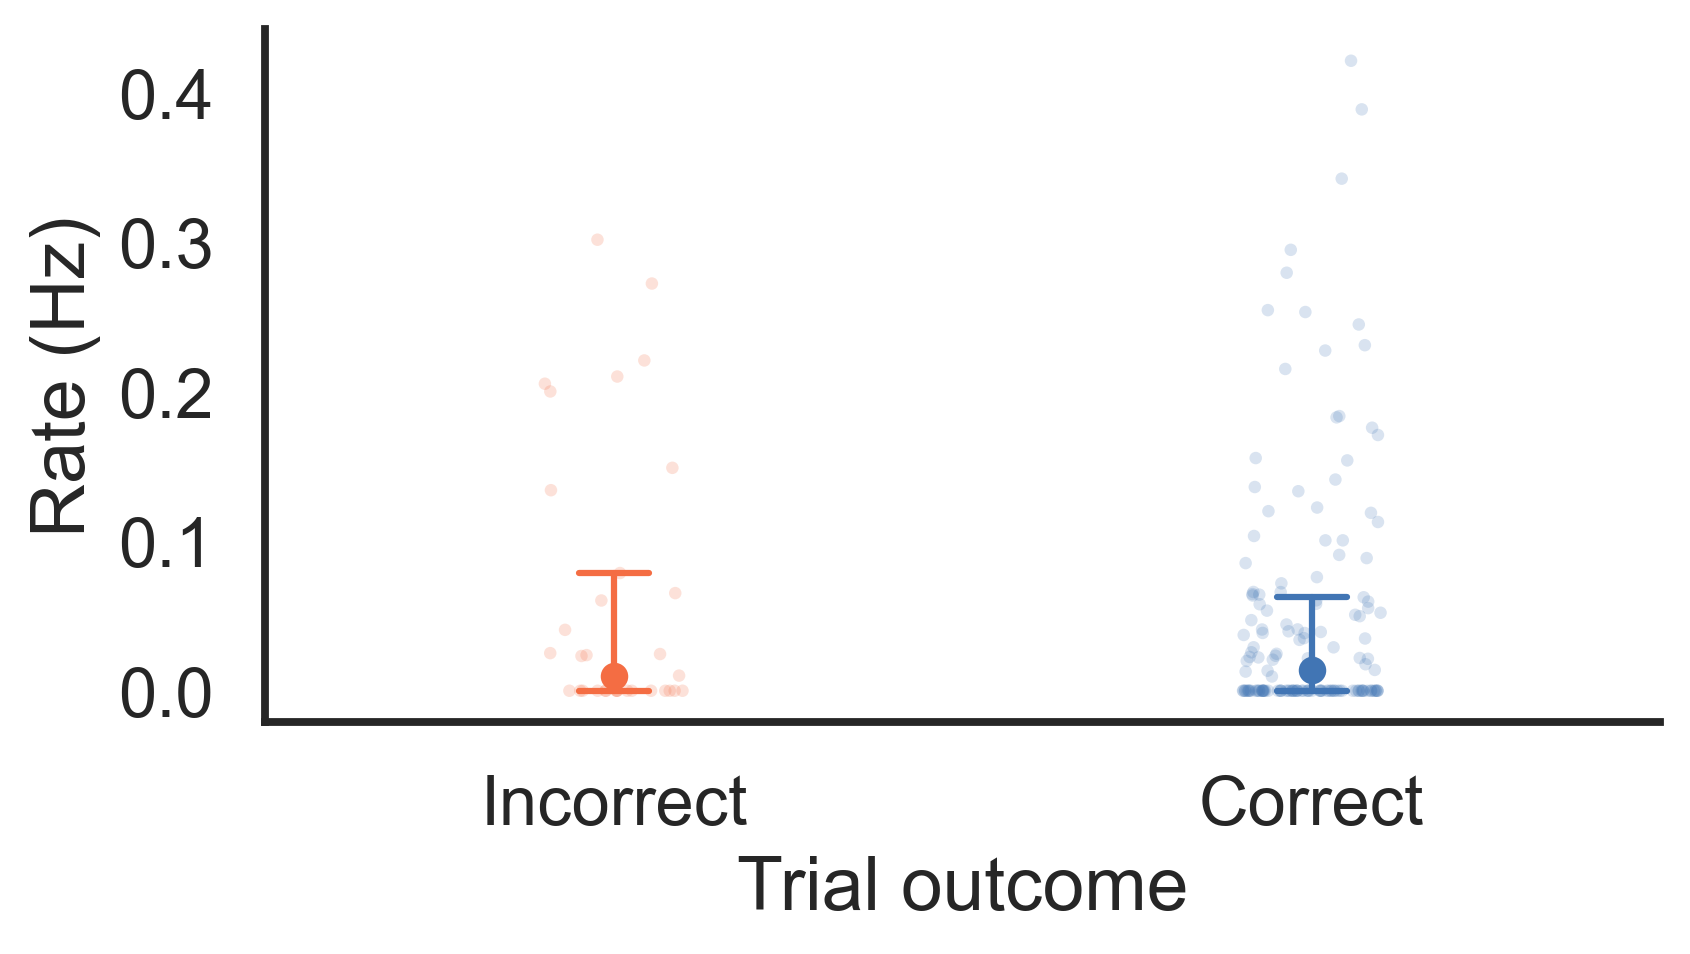

In [115]:
sns.set(style='white', context=plot_context)
plt.figure(figsize=(6,3), dpi=300)

g=sns.stripplot(
    data=rate_by_outcome,  x='outcome', y='rate', hue='outcome',
    palette=[colors[2], colors[13]], s=3, linewidth=0, alpha=.2, jitter=.1
)

sns.pointplot(
    data=rate_by_outcome,  x='outcome', y='rate', hue='outcome', palette=[colors[2], colors[13]], 
    estimator=np.median, dodge=False, errorbar=(('pi', 50)), errwidth=1.5,  capsize=.1, markers= "o", scale=.5
)

g.set_xlabel('Trial outcome')
g.set_xticklabels(['Incorrect', 'Correct'])
g.set_ylabel('Rate (Hz)')
g.get_legend().remove()
sns.despine()

<br>

### Duration distribution by task phase

Are the duration of events modulated by task phase?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


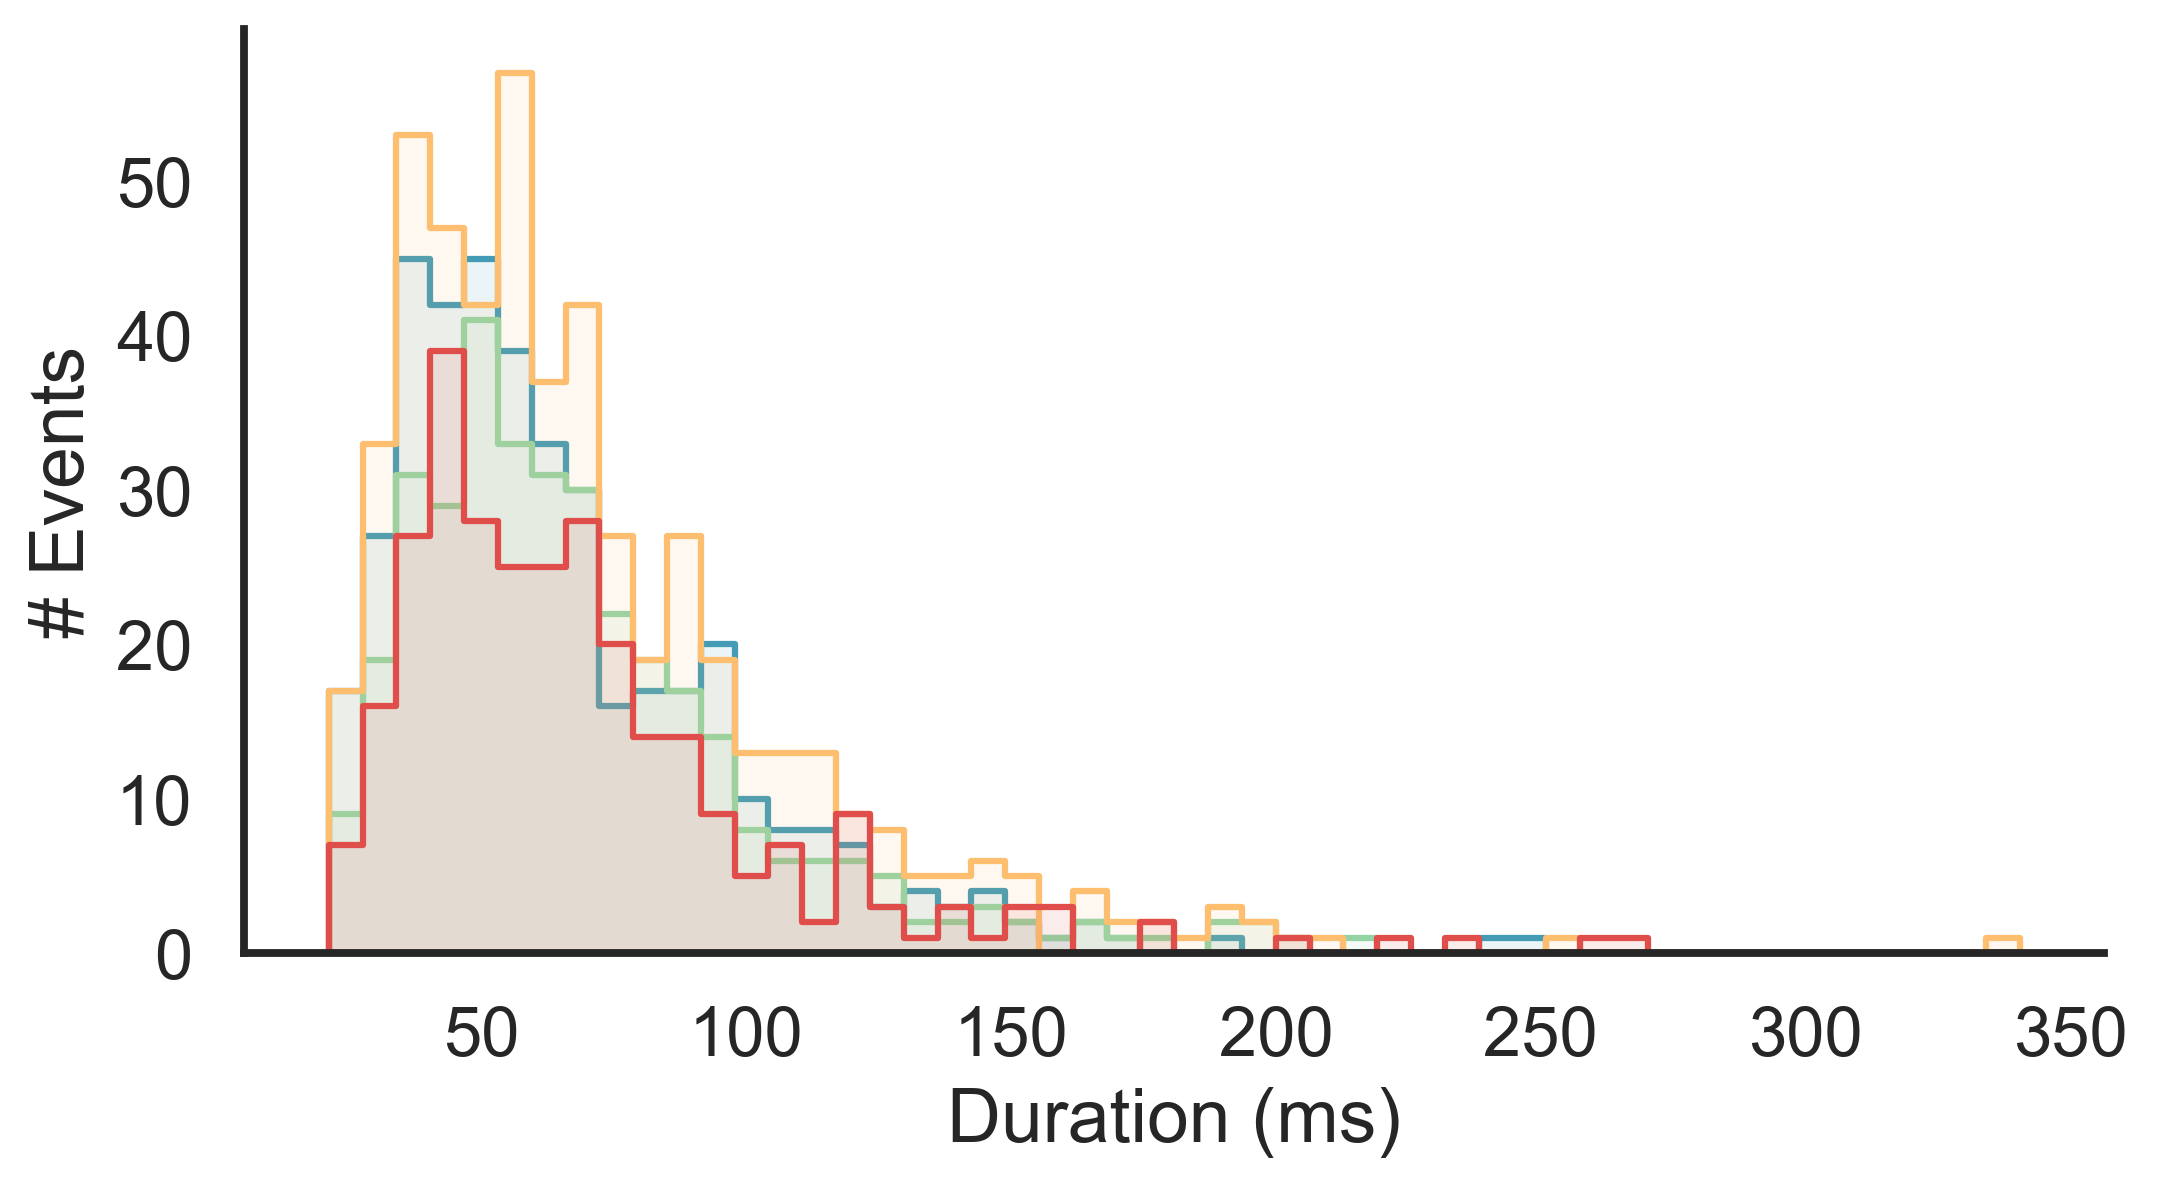

In [107]:
sns.set(context=plot_context, style='white')
plt.figure(figsize=(8,4), dpi=300)

sns.histplot(
    data=ripples_clean,
    x='duration_ms', hue='phase',
    palette=phase_palette, linewidth=1.5, 
    hue_order=order, legend=True,
    element="step", fill=True, bins=50, alpha=.1
)

plt.legend(bbox_to_anchor=(1,1), frameon=False)
plt.xlabel('Duration (ms)')
plt.ylabel('# Events')
sns.despine()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


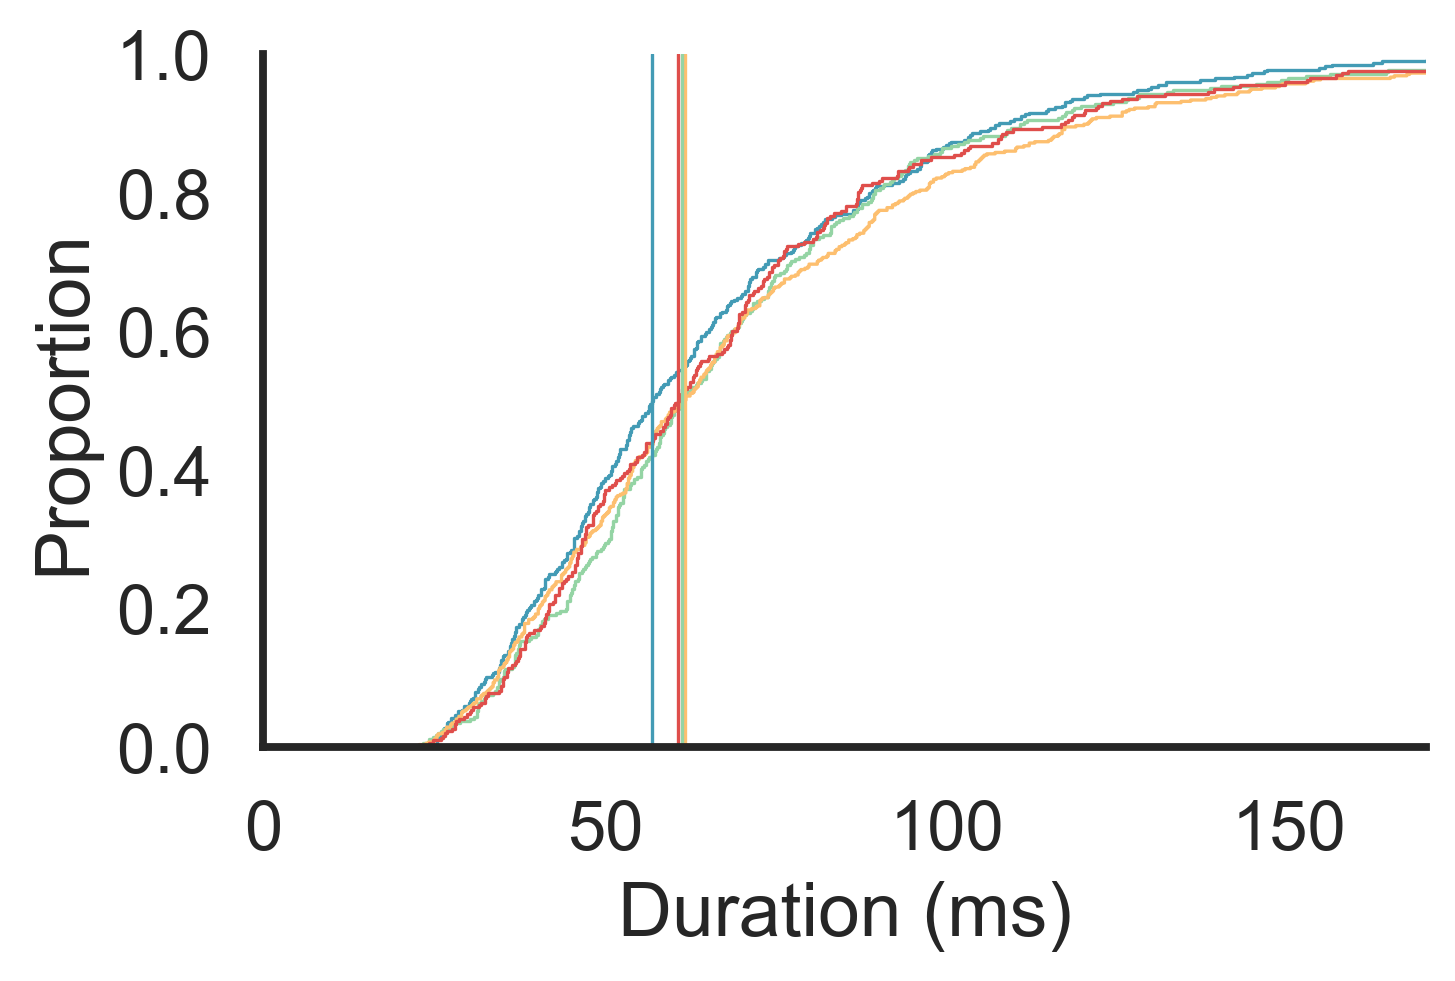

In [77]:
sns.set(context=plot_context, style='white')
plt.figure(figsize=(5,3), dpi=300)

sns.ecdfplot(
    data=ripples_clean, x='duration_ms', hue='phase',
    palette=phase_palette, linewidth=.8, hue_order=order
)

plt.legend(bbox_to_anchor=(1,1), frameon=False)
plt.xlabel('Duration (ms)')
plt.ylabel('Proportion')
plt.xlim([0,170])
plt.xticks(rotation=0)
sns.despine()

# Plot medians
plt.axvline(
    x=np.median(ripples_clean.loc[ripples_clean.phase=='ITI','duration_ms']), 
    color=phase_palette[0], linewidth=.8
)
plt.axvline(
    x=np.median(ripples_clean.loc[ripples_clean.phase=='Sample','duration_ms']), 
    color=phase_palette[1], linewidth=.8
)
plt.axvline(
    x=np.median(ripples_clean.loc[ripples_clean.phase=='Delay','duration_ms']), 
    color=phase_palette[2], linewidth=.8
)
plt.axvline(
    x=np.median(ripples_clean.loc[ripples_clean.phase=='Test','duration_ms']), 
    color=phase_palette[3], linewidth=.8
)

In [78]:
print(
'ITI Median: {}, Sample Median: {}, Delay Median: {}, Test Median: {}'.format(
    np.median(ripples_clean.loc[ripples_clean.phase=='ITI','duration_ms']),
    np.median(ripples_clean.loc[ripples_clean.phase=='Sample','duration_ms']),
    np.median(ripples_clean.loc[ripples_clean.phase=='Delay','duration_ms']),
    np.median(ripples_clean.loc[ripples_clean.phase=='Test','duration_ms'])
))

# Perform the Kruskal-Wallis H-test
stat, p = kruskal(
    ripples_clean.loc[ripples_clean.phase=='ITI','duration_ms'],    
    ripples_clean.loc[ripples_clean.phase=='Sample','duration_ms'],     
    ripples_clean.loc[ripples_clean.phase=='Delay','duration_ms'], 
    ripples_clean.loc[ripples_clean.phase=='Test','duration_ms']
)

print('H: {}, p={}'.format(stat, p))

ITI Median: 60.69999999999709, Sample Median: 61.599999999998545, Delay Median: 61.19999999987158, Test Median: 56.90000000002726
H: 4.387962978778046, p=0.2225040973164966


### Event duration by outcome

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


66.19999999981019 58.800000000076125


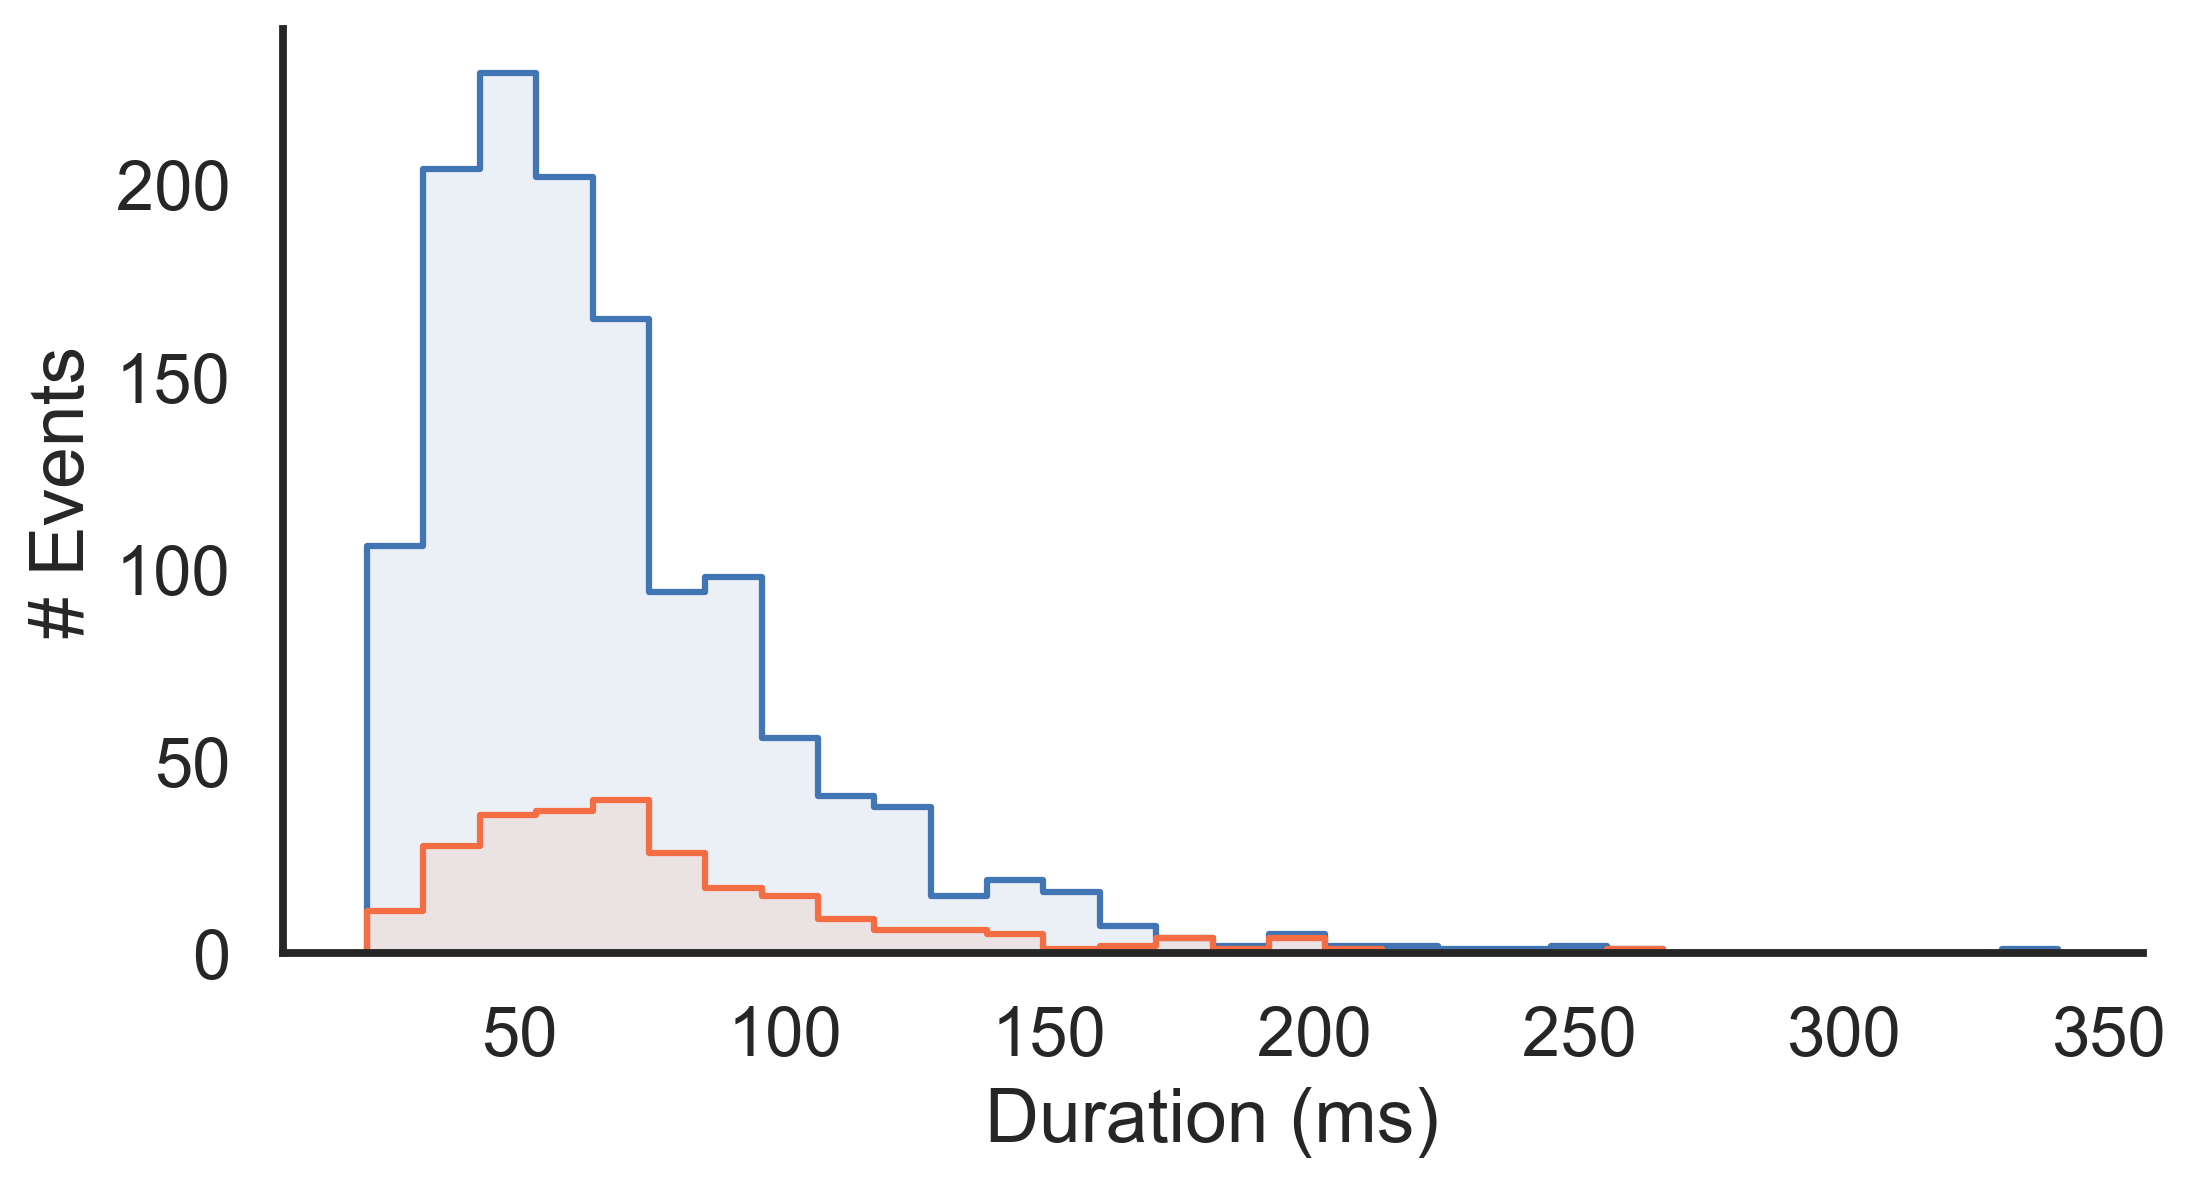

In [106]:
print(np.median(ripples_clean.loc[ripples_clean.outcome==0,'duration_ms']), 
    np.median(ripples_clean.loc[ripples_clean.outcome==1,'duration_ms']))

sns.set(context=plot_context, style='white')
plt.figure(figsize=(8,4), dpi=300)

sns.histplot(
    data=ripples_clean,
    x='duration_ms', hue='outcome',
    palette=[colors[2], colors[13]], linewidth=1.5, 
    legend=True, element="step", fill=True, bins=30, alpha=.1
)

plt.legend(bbox_to_anchor=(1,1), frameon=False)
plt.xlabel('Duration (ms)')
plt.ylabel('# Events')
sns.despine()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


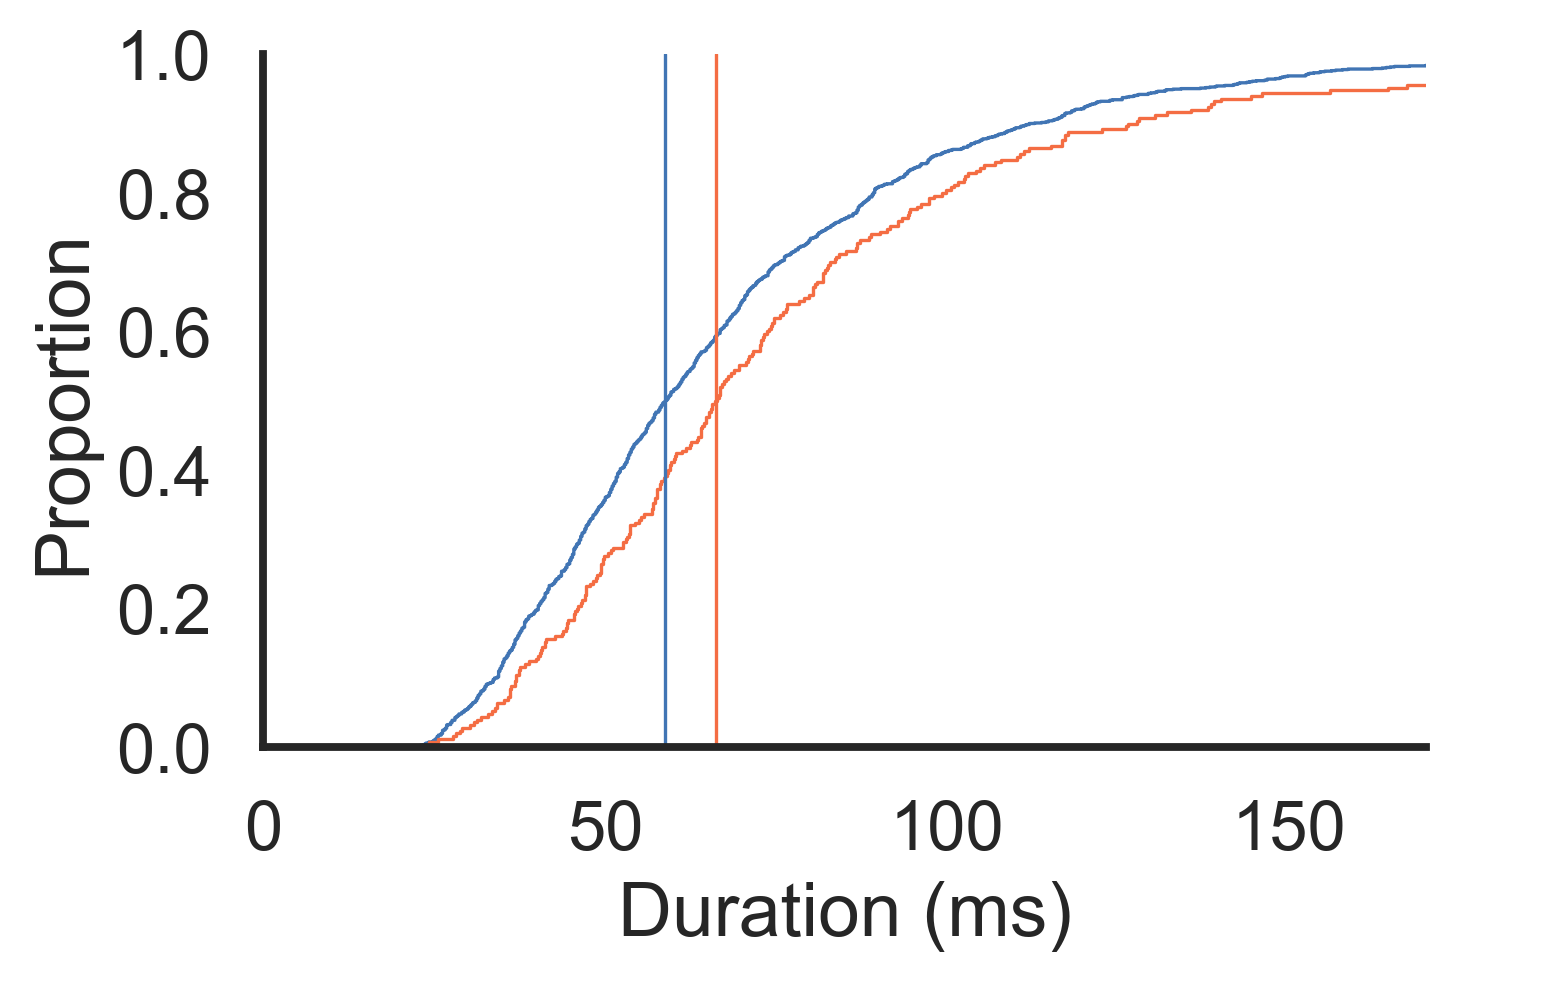

In [88]:
sns.set(context=plot_context, style='white')
plt.figure(figsize=(5,3), dpi=300)

sns.ecdfplot(
    data=ripples_clean, x='duration_ms', hue='outcome',
    palette=[colors[2], colors[13]], linewidth=.8)
    
plt.legend(bbox_to_anchor=(1,1), frameon=False)
plt.xlabel('Duration (ms)')
plt.ylabel('Proportion')
plt.xlim([0,170])
plt.xticks(rotation=0)
sns.despine()

# Plot medians
plt.axvline(
    x=np.median(ripples_clean.loc[ripples_clean.outcome==0,'duration_ms']), color=colors[2], linewidth=.8)
plt.axvline(
    x=np.median(ripples_clean.loc[ripples_clean.outcome==1,'duration_ms']), color=colors[13], linewidth=.8)

### Trials with events by phase

In [122]:
rate_by_phase_above0.groupby('phase').count()['trial_nr']

phase
Delay      98
ITI        89
Sample    124
Test      110
Name: trial_nr, dtype: int64

In [121]:
rate_by_phase.groupby('phase').count()['trial_nr']

phase
Delay     181
ITI       180
Sample    180
Test      181
Name: trial_nr, dtype: int64

In [117]:
with_events = 100*(rate_by_phase_above0.groupby('phase').count()/rate_by_phase.groupby('phase').count())['trial_nr']
with_events

phase
Delay     54.143646
ITI       49.444444
Sample    68.888889
Test      60.773481
Name: trial_nr, dtype: float64

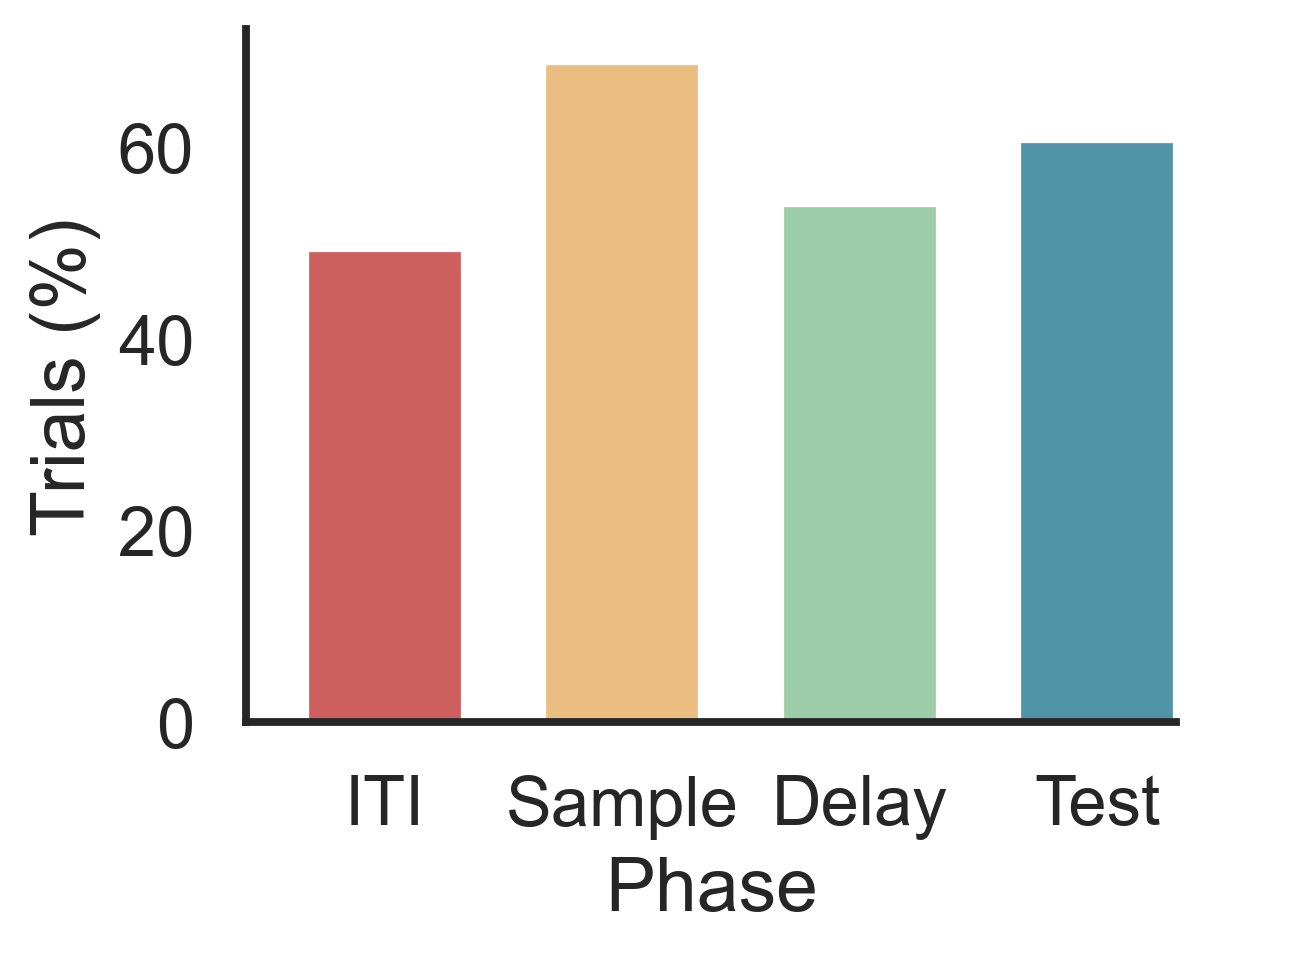

In [103]:
sns.set(context=plot_context, style='white')
plt.figure(figsize=(4,3), dpi=300)

ax=sns.barplot(
    data=with_events.reset_index(), x='phase', hue='phase', y='trial_nr',
    palette=phase_palette, hue_order=order, order=order, 
)

new_width=.8
# Get number of bars
num_bars = 4

# Get current axis and figure
fig = plt.gcf()
ax = fig.gca()

for patch in ax.patches:
    
    current_width = patch.get_width()
    diff = current_width - new_width
    # Change the bar width
    patch.set_width(new_width)
    patch.set_x(patch.get_x() + diff * 0.5)

# Center the bars
ax.set_xlim(-1, num_bars - 0.3)
ax.set_xticks([-0.3, .9, 2.1, 3.3])
ax.set_xticklabels(order)      
plt.legend([], bbox_to_anchor=(1,1), frameon=False)
plt.xlabel('Phase')
plt.ylabel('Trials (%)')
sns.despine()

### Trials with events by outcome

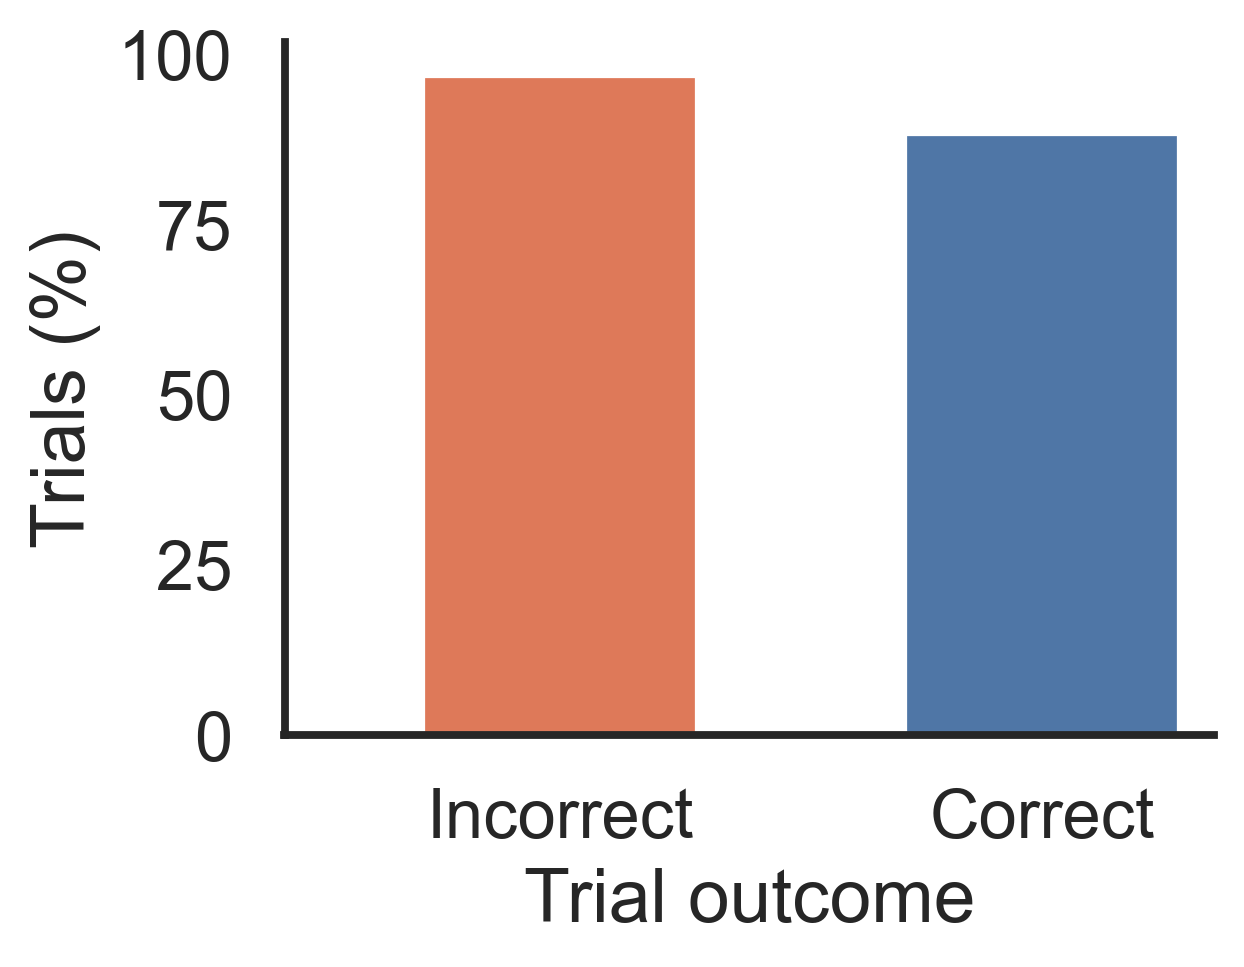

In [116]:
rate_by_outcome_above0 = rate_by_outcome[rate_by_outcome.ripples > 0]
with_events_outcome = 100*(
    rate_by_outcome_above0.groupby('outcome').count()/
    rate_by_outcome.groupby('outcome').count())['trial_nr'].reset_index()

# Ensure the 'outcome' column is treated as a string or category
with_events_outcome['outcome'] = with_events_outcome['outcome'].astype(str)


sns.set(context=plot_context, style='white')
plt.figure(figsize=(4,3), dpi=300)

ax=sns.barplot(
    data= with_events_outcome, x='outcome', hue='outcome', y='trial_nr',
    palette=[colors[2], colors[13]]
)

new_width=.8
# Get current axis and figure
fig = plt.gcf()
ax = fig.gca()

for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_width
        # Change the bar width
        patch.set_width(new_width)
        patch.set_x(patch.get_x() + diff * 0.5)

# Get number of bars
num_bars = 2

# Center the bars
ax.set_xlim(-1, num_bars - 0.3)
ax.set_xticks([-.2, 1.2])
ax.set_xticklabels(['Incorrect', 'Correct'])
plt.legend([], frameon=False)
plt.xlabel('Trial outcome')
plt.ylabel('Trials (%)')
sns.despine()

## Percentage of trials with ripple occurrence at the reward port
- By trial outcome and task phase

In [218]:
rw1_rois = pd.read_csv(os.path.join(main_path, 'rw1_rois.csv'))
rw2_rois = pd.read_csv(os.path.join(main_path, 'rw2_rois.csv'))

In [219]:
# add column to ripple - if in reward port
def add_in_ports_info(row, rw1_rois, rw2_rois, colx, coly):
    '''
    Returns a boolean indicating if ripple row occurred close to reward ports
    '''
    
    session=row['session_code']
    session_rw1 = rw1_rois[rw1_rois['session']==session]
    session_rw2 = rw2_rois[rw2_rois['session']==session]
    x=row[colx]
    y=row[coly]
    
    if  ((session_rw1['x'].iloc[0]-20 <= x <=session_rw1['x'].iloc[0]+20) &\
        (session_rw1['y'].iloc[0]-30 <= y <= session_rw1['y'].iloc[0]+30)) |\
        ((session_rw2['x'].iloc[0]-20 <= x <=session_rw2['x'].iloc[0]+20) &\
         (session_rw2['y'].iloc[0]-30 <= y <= session_rw2['y'].iloc[0]+30)):   
        return 1
    else:
        return 0

In [220]:
ripples_clean['at_reward']=ripples_clean.apply(add_in_ports_info, 
                                   args=(rw1_rois, rw2_rois,'x_ripple', 'y_ripple',), 
                                   axis=1)

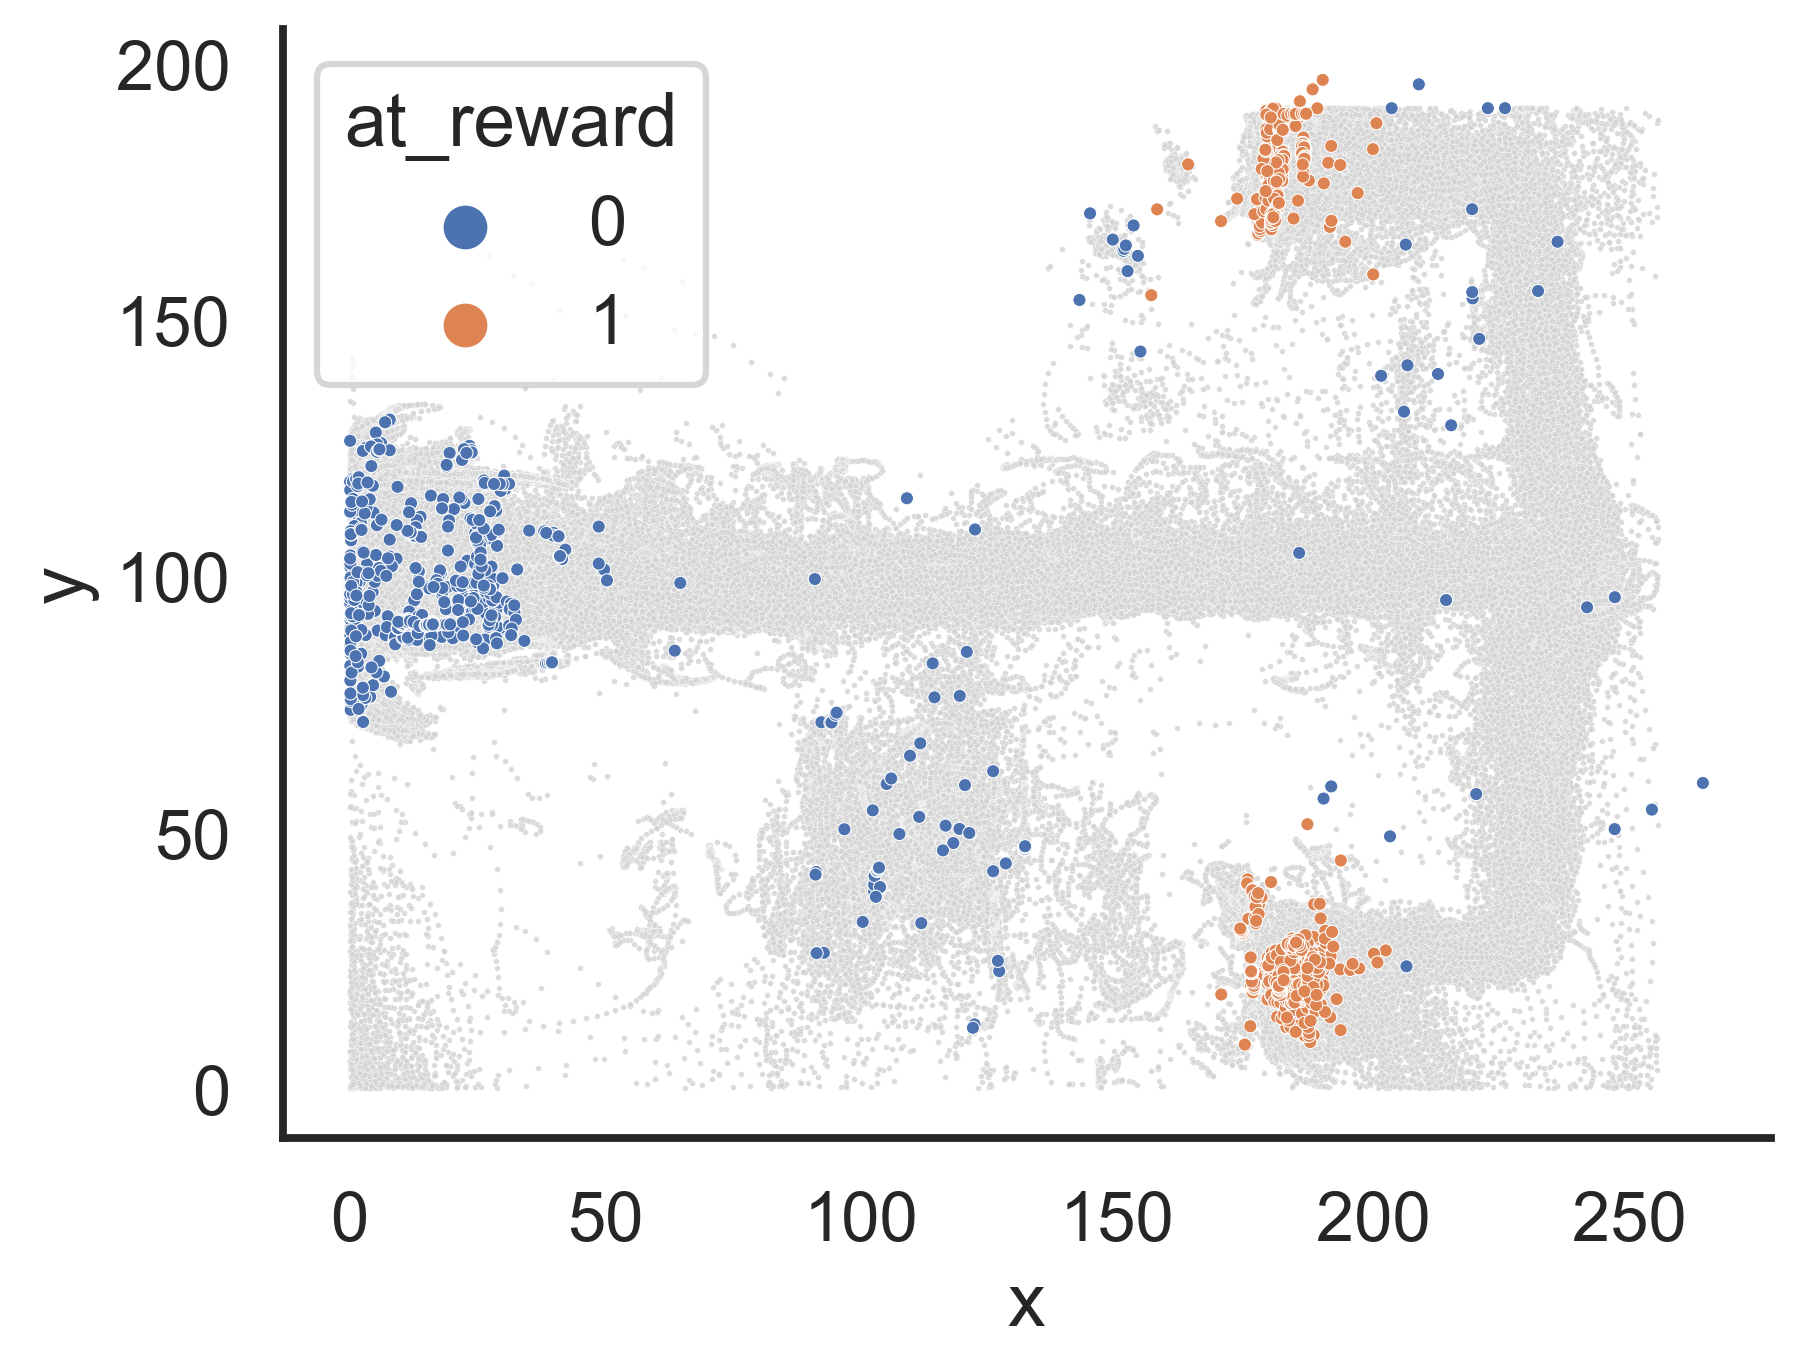

In [221]:
plt.figure(dpi=300)
g = sns.scatterplot(
    data = position,
    x='x', y='y',
    color='lightgray', s=2, alpha=.8
)
sns.scatterplot(
    data = ripples_clean,
    x='x_ripple', y='y_ripple',hue='at_reward',
    s=10)

sns.despine()

In [146]:
ripples_at_rw =ripples_clean.groupby(['phase', 'at_reward']).count()
#ripples_at_rw

In [147]:
# Label trials with ripples as having them at reward port during test 
reward_count=ripples_clean.groupby(
    ['session_code', 'trial_nr', 'phase','outcome'])['at_reward'].sum().reset_index()
reward_count['has_rw_ripples']=np.where(reward_count.at_reward>0, 1, 0)

# Calculate all trial combinations
trial_combos=position[['session_code', 'trial_nr', 'phase',  'outcome']].groupby(
    ['session_code', 'trial_nr','phase','outcome']).size(
    ).reset_index(
    ).drop([0], axis=1)

trial_combos = trial_combos[trial_combos.phase.isin(['Sample', 'Test'])]

In [148]:
# Merge both
trial_rw_ripples = pd.merge(trial_combos,
        reward_count,
        how='left',
        on=['session_code', 'trial_nr', 'phase', 'outcome']).drop(['at_reward'], axis=1).fillna(0)

# Calculate percentage of trials with ripples at reward port during sample vs. test 
num=trial_rw_ripples.groupby(['phase', 'outcome'])['has_rw_ripples'].sum()
denom=trial_rw_ripples.groupby(['phase', 'outcome'])['has_rw_ripples'].count()

trials_rw_ripples_percent=(num/denom).reset_index().rename({'has_rw_ripples': 'percentage'}, axis=1)
trials_rw_ripples_percent['percentage']=trials_rw_ripples_percent['percentage']*100

In [150]:
#trials_rw_ripples_percent

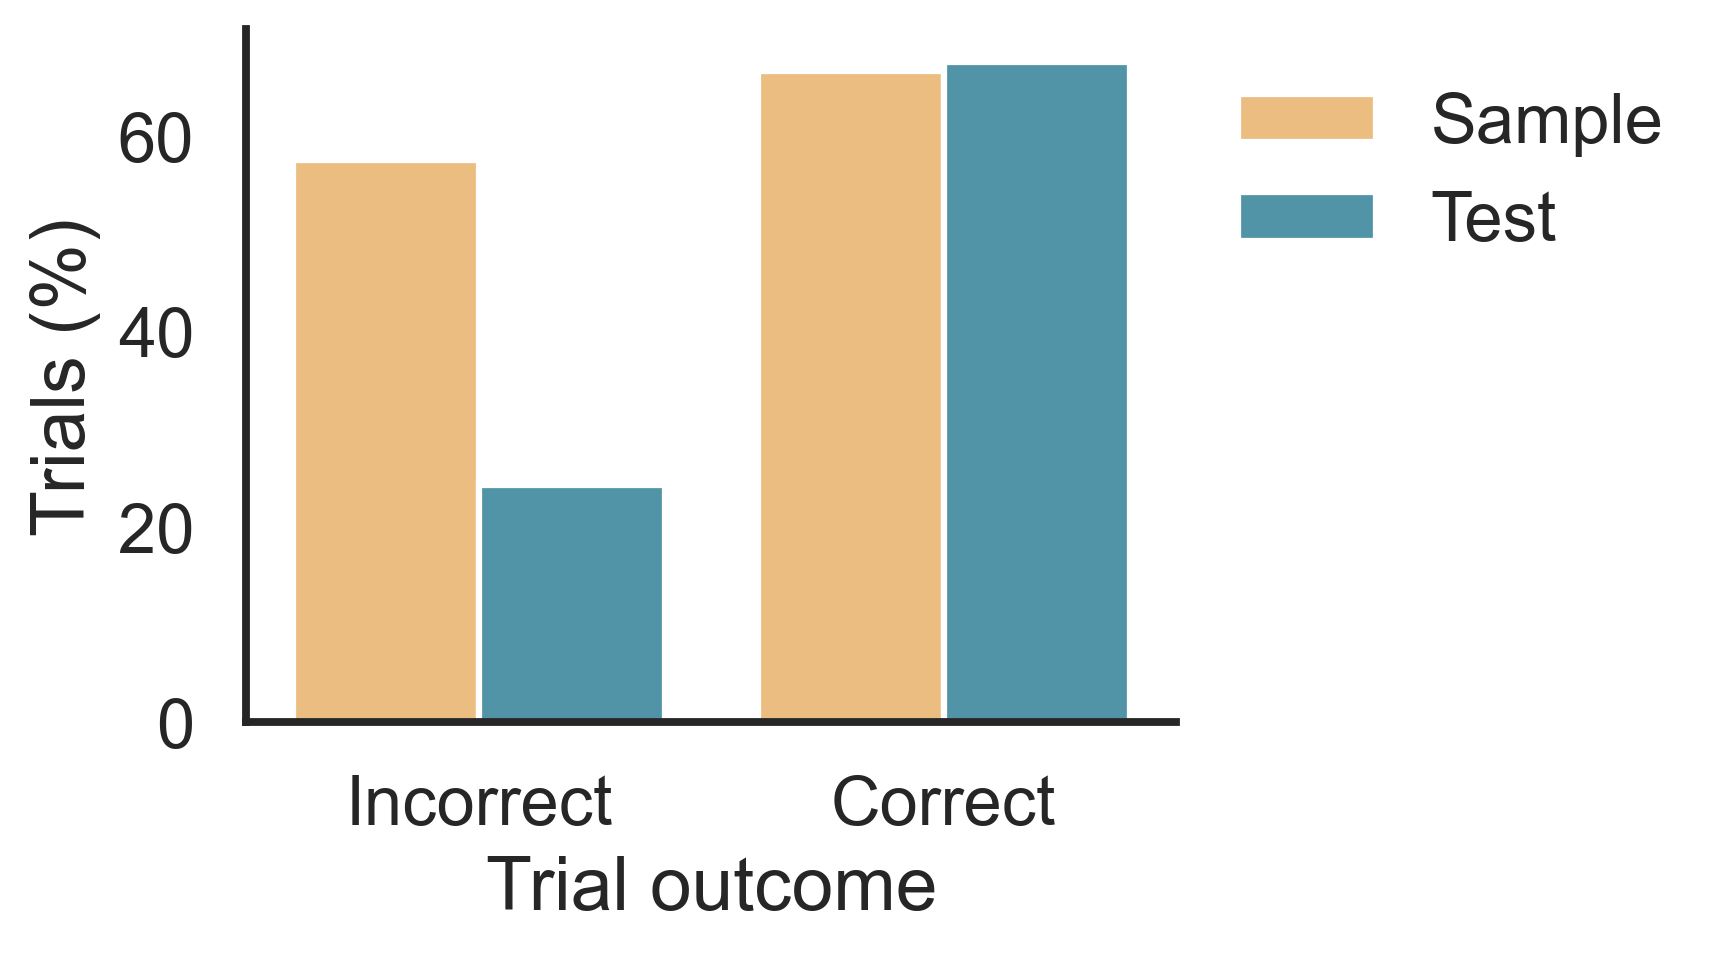

In [151]:
sns.set(style='white', context=plot_context)
plt.figure(figsize=(4,3), dpi=300)
g=sns.barplot(
    data=trials_rw_ripples_percent,  x='outcome', y='percentage', hue='phase',
    palette=[phase_palette[1], phase_palette[3]])


g.set_xlabel('Trial outcome')
g.set_ylabel('Trials (%)')
g.set_xticklabels(['Incorrect', 'Correct'])
plt.legend(bbox_to_anchor=(1,1), frameon=False)
sns.despine()

### SWR rate at reward ports 
 Number of SWRs at reward ports / Time spent at reward port.

In [153]:
rw_ripples=ripples_clean[ripples_clean.at_reward==1]
position_trj = position[position.phase.isin(['Sample', 'Test'])]

In [145]:
data = pd.merge(
    position_trj,
    rw1_rois,
    how='left',
    on=['session']
).rename(
    {'x_x':'x',
    'y_x':'y',
    'x_y':'rw1_x',
    'y_y':'rw1_y'}, axis=1
).merge(
    rw2_rois,
    how='left',
    on=['session']
).rename(
    {'x_x':'x',
    'y_x':'y',
    'x_y':'rw2_x',
    'y_y':'rw2_y'}, axis=1
).drop(
    ['width_x', 'width_y', 'height_x', 'height_y'], 
    axis=1
)


rw_data = data[
    ((data.x.between(data.rw1_x-20, data.rw1_x+20)) & (data.y.between(data.rw1_y-30, data.rw1_y+30))) | 
    ((data.x.between(data.rw2_x-20, data.rw2_x+20)) & (data.y.between(data.rw2_y-30, data.rw2_y+30)))
]

NameError: name 'position_trj' is not defined

In [71]:
time_at_rw = rw_data.groupby(
    ['session', 'trial_nr', 'run_type', 'outcome']
).agg(
    {'timestamp':['min', 'max']}
).reset_index()

# Re-arrange dataframe columns from multi-index
time_at_rw.columns=list(map(''.join, time_at_rw.columns.values))
# Calculate time spent at reward port
time_at_rw['deltat']=time_at_rw.timestampmax-time_at_rw.timestampmin

#Calculate ripple count per trial and run
rw_ripple_count=rw_ripples.groupby(['session_code','trial_nr', 'run_type','outcome']).size().reset_index().rename(
    {'session_code':'session', 0:'n_ripples'}, axis=1)

In [72]:
# Calculate rate
rw_rate= time_at_rw.merge(
    rw_ripple_count, 
    how='left',
    on=['session', 'trial_nr', 'run_type', 'outcome']).fillna(0)

rw_rate['rate']=rw_rate['n_ripples']/rw_rate['deltat']

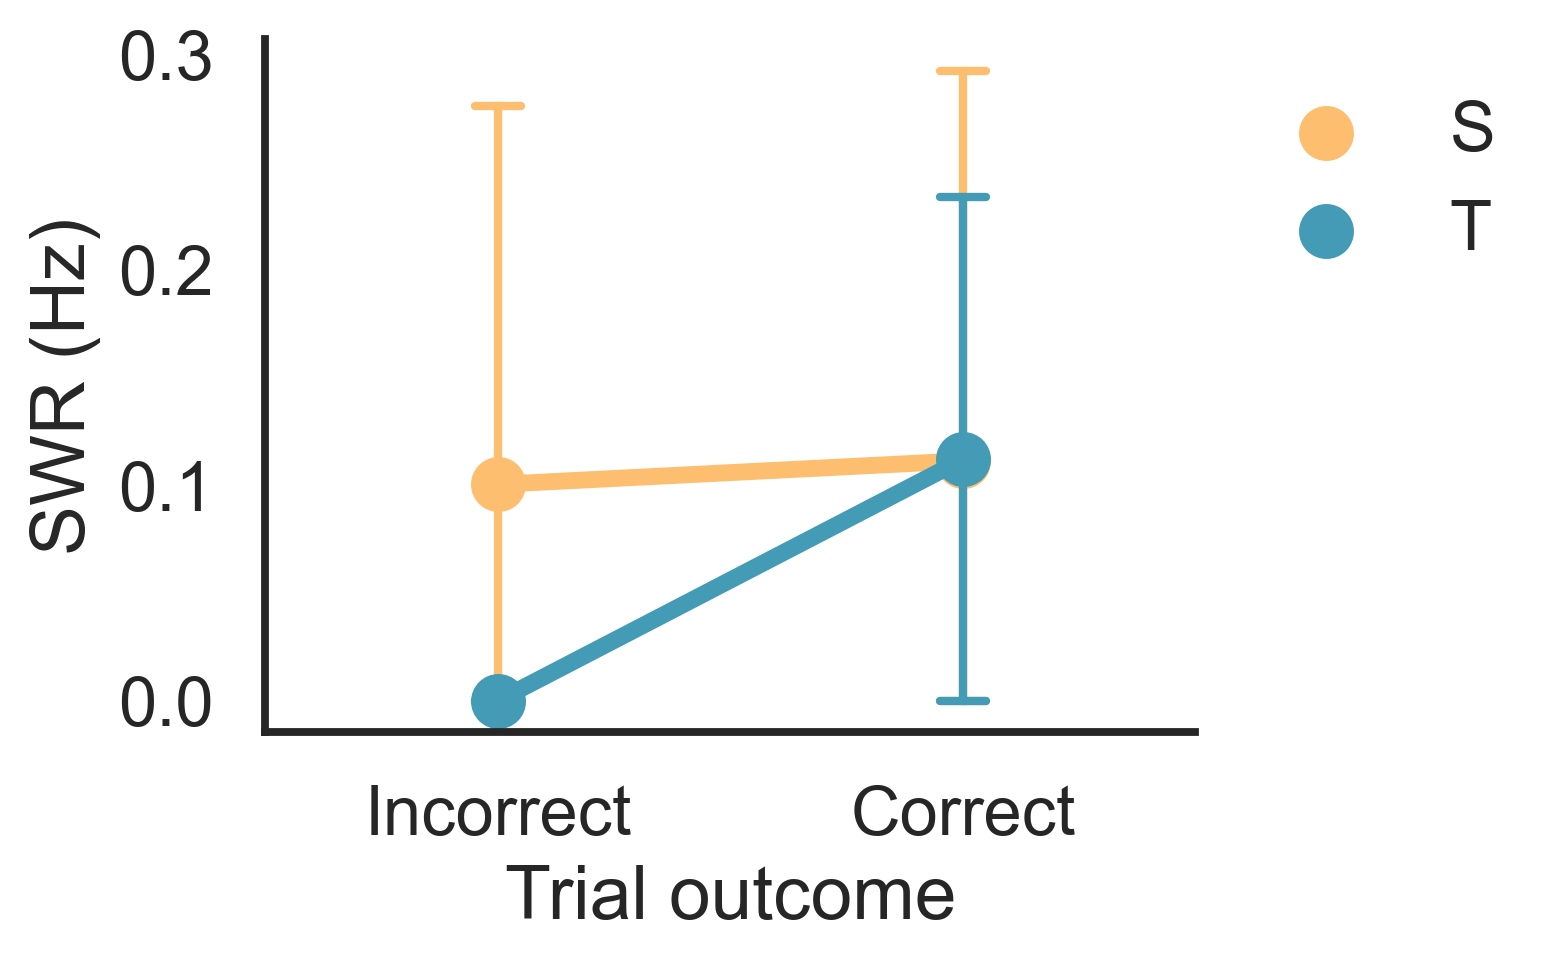

In [76]:
sns.set(style='white', context=plot_context)
plt.figure(dpi=300, figsize=(4,3))
g=sns.pointplot(
    data=rw_rate,
    x='outcome',
    y='rate',
    hue='run_type',
    estimator=np.median,
    errorbar=("pi", 50),
    palette=[phase_palette[1], phase_palette[3]],
    errwidth=2, capsize=.1)

g.set_xlabel('Trial outcome')
g.set_ylabel('SWR (Hz)')
g.set_xticklabels(['Incorrect', 'Correct'])
plt.legend(bbox_to_anchor=(1,1), frameon=False)

sns.despine()

## Rate within sessions
Rate of SWR occurrence = Number of events in a given trial / trial duration. A trial includes ITI before trial, Sample, Delay and Test.

In [156]:
# Calculate trial duration using position data
trial_duration = position.groupby(['session_code','trial_nr']).apply(lambda x:
                                                     x['timestamp'].iloc[-1] - x['timestamp'].iloc[0])
# Calculate the SWR events / sec
rate_across_trials = ripples_clean.groupby(['session_code','trial_nr']).apply(
    lambda x, y: len(x)/y.loc[int(x.session_code.iloc[0]), x.trial_nr.iloc[0]], trial_duration)

rate_across_trials=rate_across_trials.reset_index().rename(columns={0:'rate'})

trial_duration.describe()

count    181.000000
mean     132.339854
std       58.796479
min       51.357670
25%      105.458432
50%      117.996083
75%      130.926234
max      495.714790
dtype: float64

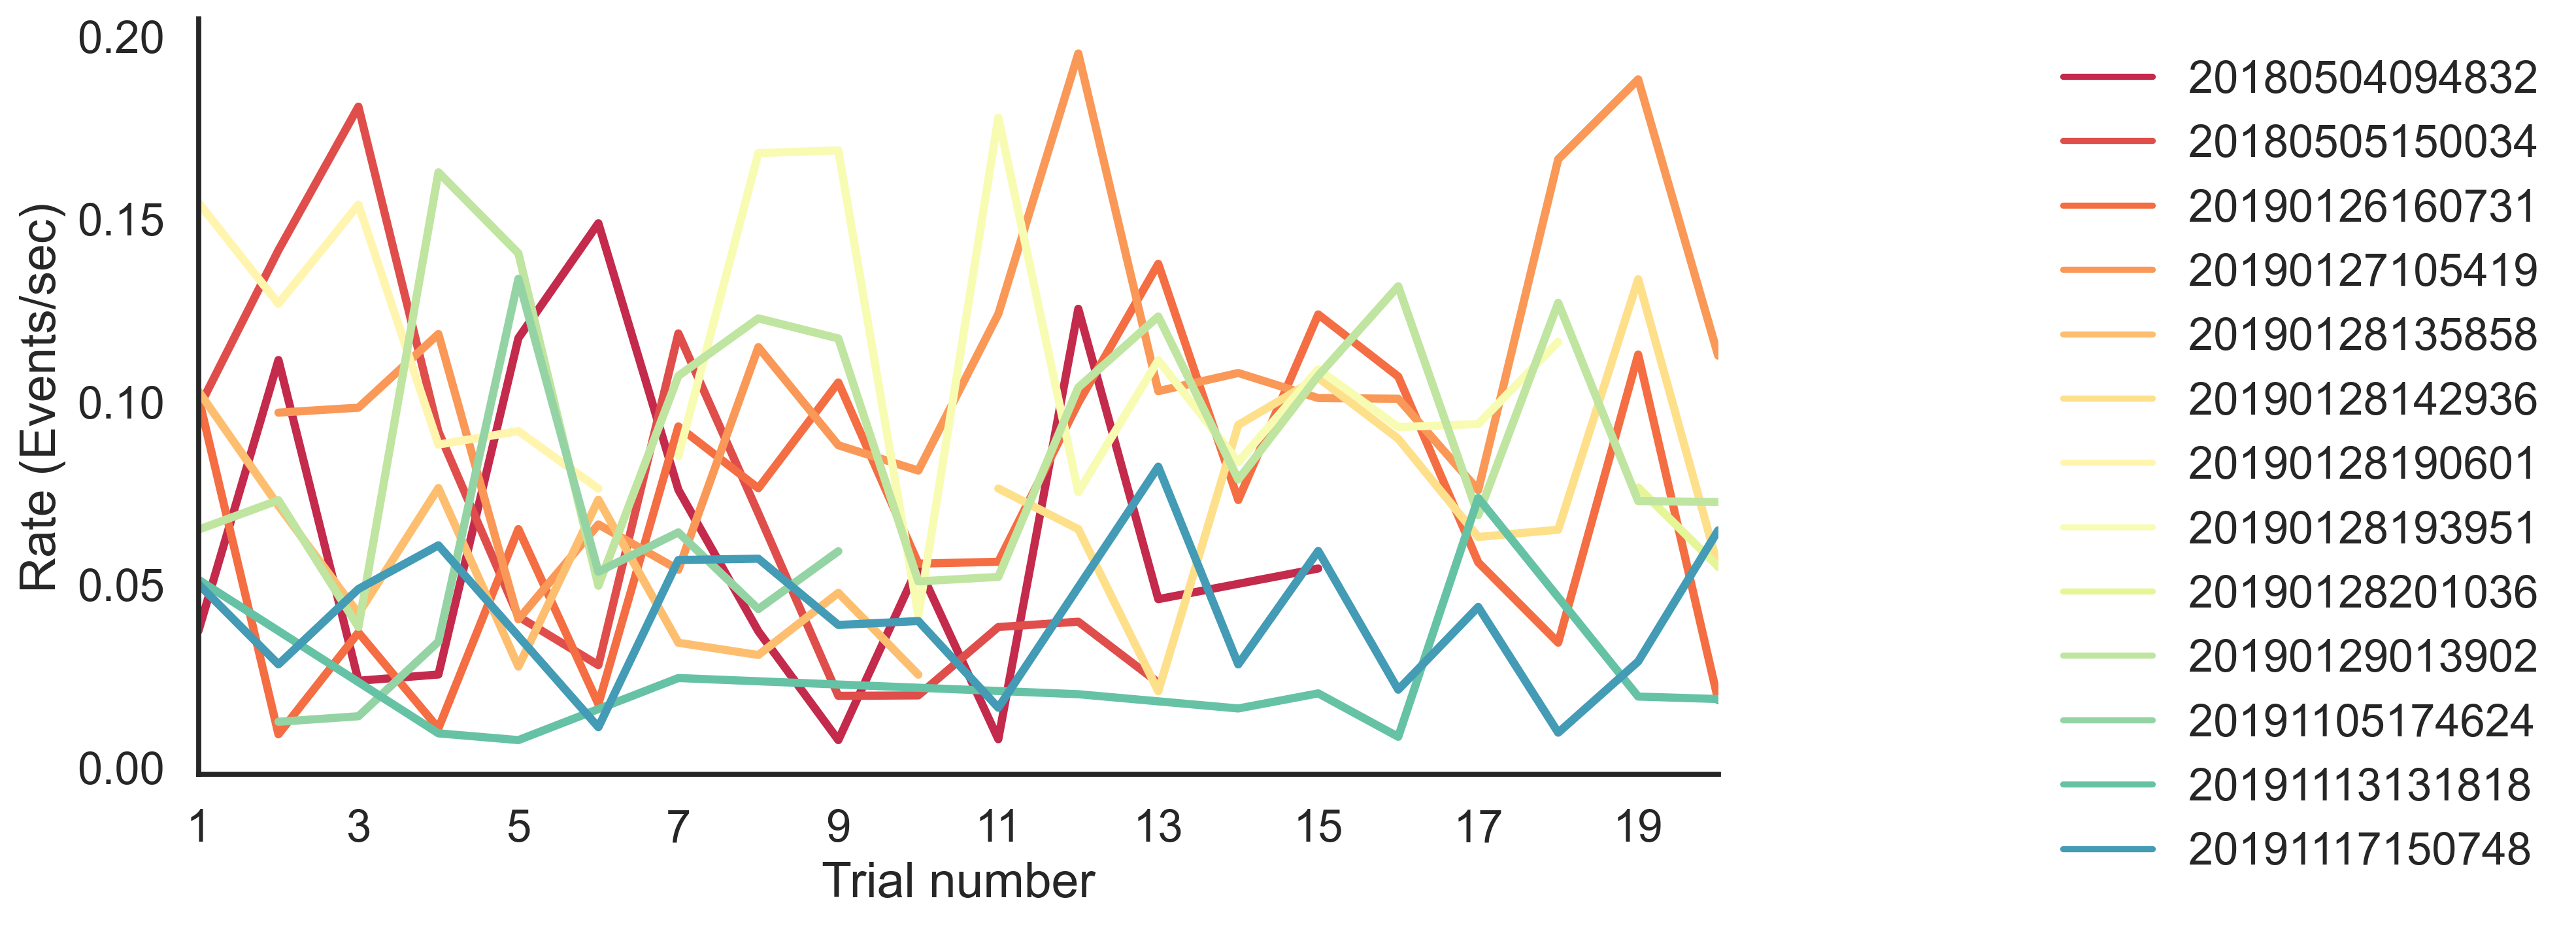

In [78]:
sns.set(style='white', context=plot_context)
plt.figure(figsize=(10,5), dpi=300)
sns.lineplot(data=rate_across_trials, y='rate', x='trial_nr', hue='session_code',
            palette=session_colors[0:len(sessions)], linewidth=3)
plt.xticks(range(1,21,2))
plt.xlabel('Trial number')
plt.ylabel('Rate (Events/sec)')
plt.xlim([1,20])
plt.legend(bbox_to_anchor=(1.2,1), frameon=False)
sns.despine()

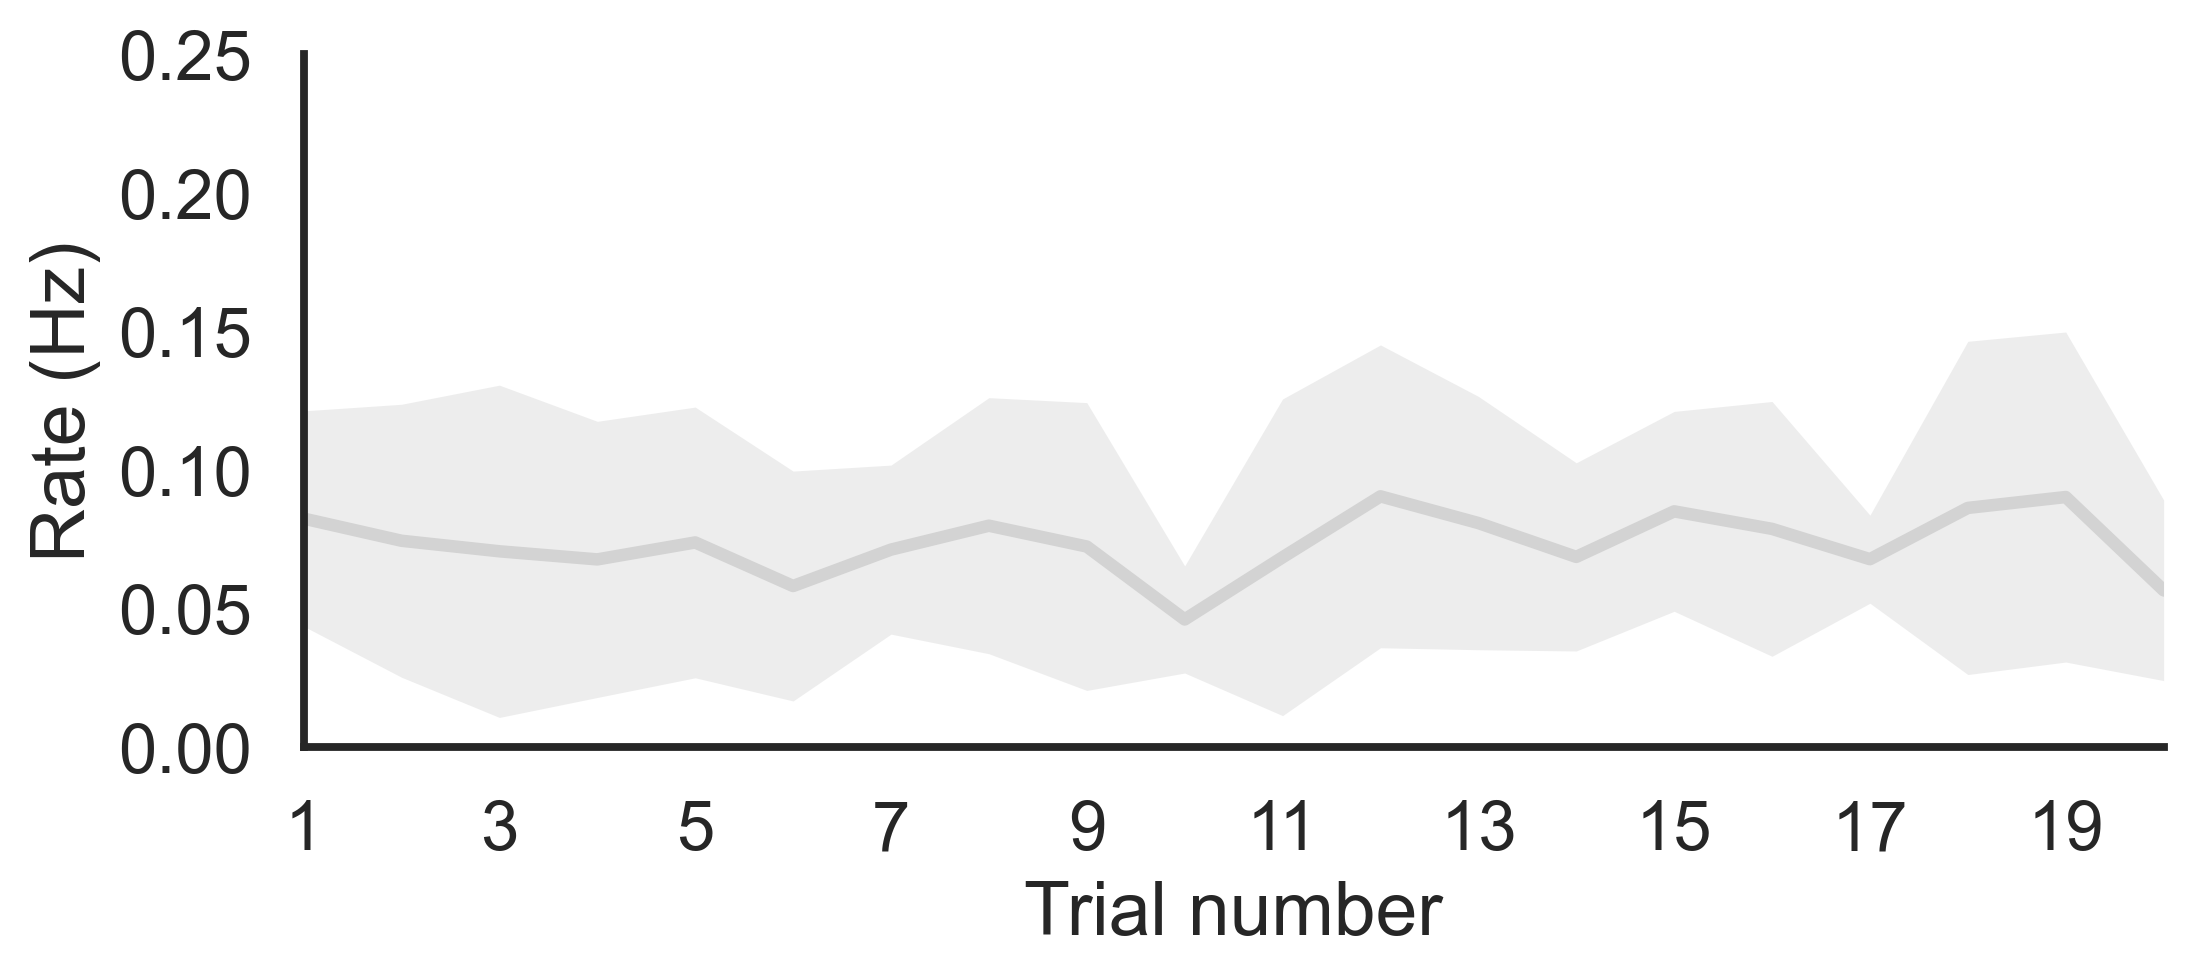

In [80]:
sns.set(style='white', context=plot_context)
plt.figure(figsize=(8,3), dpi=300)

sns.lineplot(
    data=rate_across_trials, 
    y='rate', x='trial_nr', 
    linewidth=3, errorbar='sd', color='lightgrey', err_kws={'lw':0, 'alpha':.4}
    )

plt.xticks(range(1,21,2))
plt.xlabel('Trial number')
plt.ylabel('Rate (Hz)')
plt.xlim([1,20])
plt.ylim([0,0.25])
sns.despine()